In [40]:
import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

import os
os.getcwd()

Setup complete. Using torch 2.4.1+cu121 (NVIDIA GeForce RTX 3080 Ti)


'/home/kms2069/Projects/boxmot'

# MOT Evaluation using BoxMOT (Wide Format Output)

This notebook performs Multi-Object Tracking (MOT) evaluation using the `boxmot` library and custom weights on a dataset structured in MOT17 format.

**Workflow:**
1.  **Setup:** Install necessary libraries and import modules.
2.  **Configuration:** Define paths to the dataset, weights, output directory, and algorithms to test.
3.  **Run Tracking:** Execute `boxmot` for each specified algorithm on all test sequences. This generates tracking result files (`.txt`) and visualization videos (`.mp4`).
4.  **Run Evaluation:** Calculate quantitative MOT metrics (MOTA, IDF1, IDSW, GT_IDs, Count-IDs) for each sequence using `motmetrics`.
5.  **Aggregate Results:** Combine results into a wide-format table where rows are algorithms and columns show metrics per sequence and overall summary metrics.
6.  **Display Results:** Show the final table and save it to a CSV file.
7.  **Qualitative Info:** List the paths to the generated visualization videos.
8.  **Plotting:** Provide example code to generate comparison plots from the results.

**Metrics:**
* **MOTA:** Multiple Object Tracking Accuracy
* **IDF1:** ID F1 Score (measures ID consistency)
* **IDSW:** Number of ID Switches
* **GT_IDs:** Number of unique Ground Truth object IDs in the sequence
* **Count-IDs:** Number of unique Track IDs generated by the tracker in the sequence
* **Combined_MOTA/IDF1:** Metrics calculated over all sequences combined (more robust than simple averaging)
* **Total_IDSW/GT_IDs/Count-IDs:** Sum of switches/IDs across all sequences.

In [ ]:
# Install necessary libraries
# - boxmot: For running the trackers
# - motmetrics: For calculating evaluation metrics
# - pandas: For data manipulation and table display
# - matplotlib: For plotting results
import sys
# !{sys.executable} -m pip install boxmot motmetrics pandas matplotlib numpy
import sys
# !{sys.executable} -m pip install --force-reinstall --no-cache-dir 'ultralytics @ git+https://github.com/mikel-brostrom/ultralytics.git'

In [ ]:
import sys
# !{sys.executable} -m pip install "pandas<2.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 25.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boxmot 10.0.78 requires pandas<3.0.0,>=2.0.0, but you have pandas 1.5.3 which is incompatible.
boxmot 10.0.78 requires torchvision<0.18.0,>=0.17.1; sys_platform == "linux" or sys_platform == "win32", but you have torchvision 0.19.1 which is incompatible.


In [79]:
# Import libraries  cell1
import subprocess
from pathlib import Path
import pandas as pd
import logging
import motmetrics as mm
import numpy as np
import matplotlib.pyplot as plt # For plotting later
import os

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
log = logging.getLogger()

# Configure pandas display options for wider tables
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000) # Adjust console width if needed
pd.set_option('display.float_format', '{:.3f}'.format) # Set default float format

## 1. Configuration

**Important:** Update the following paths and parameters according to your setup.
* `dataset_root`: Path to your MOT-formatted dataset (containing the `test` folder).
* `output_dir`: Directory where results (tracking files, videos, CSV) will be saved.
* `algorithms`: List of tracker names supported by `boxmot` (e.g., 'ByteTrack', 'BoTSORT', 'DeepOCSORT').
* `det_weights`: Path to your trained detection model weights (`.pt` file).
* `reid_weights`: Path to your trained Re-ID model weights (`.pt` file).
* `conf_threshold`: Confidence threshold for detection during tracking.
* `iou_threshold`: IoU threshold used by `motmetrics` for matching detections to ground truth.

In [80]:
# --- Configuration ---     cell2
# !!! PLEASE UPDATE THESE PATHS AND PARAMETERS !!!
dataset_root = '/home/kms2069/Projects/boxmot/assets/polyp_test_mot' # e.g., './personal_dataset'
output_dir = 'runs/mot_eval_notebook'
algorithms = ['ByteTrack', 'BoTSORT', 'DeepOCSORT'] # Trackers to evaluate
det_weights = 'yolov8m_polypPNG7.4_best.pt' # e.g., './weights/yolov8n_person.pt'
reid_weights = 'osnet_ain_x1_0_polyp.pt' # e.g., 'osnet_x0_25_msmt17.pt'

conf_threshold = 0.82 # Detection confidence threshold for tracker
iou_threshold = 0.7 # IoU threshold for motmetrics matching
device = '0' # Set GPU device if needed, otherwise uses CPU by default in boxmot
# --------------------

# --- Path Setup ---
dataset_root = Path(dataset_root)
output_base_dir = Path(output_dir)
det_weights = Path(det_weights)
reid_weights = Path(reid_weights)
test_dir = dataset_root / 'test'

# Create output directory if it doesn't exist
output_base_dir.mkdir(parents=True, exist_ok=True)

# --- Validation ---
if not test_dir.is_dir():
    log.error(f"Dataset test directory not found: {test_dir}")
    # Stop execution or raise error in a notebook context if needed
    assert False, f"Dataset test directory not found: {test_dir}"
if not det_weights.is_file():
    log.warning(f"Detection weights file not found: {det_weights}")
    # Depending on the tracker, this might be an error
if not reid_weights.is_file() and any(algo in ['BoTSORT', 'DeepOCSORT'] for algo in algorithms):
     log.warning(f"ReID weights file not found: {reid_weights}, but required by BoTSORT/DeepOCSORT")
     # This might cause errors later for ReID-based trackers

log.info(f"Dataset Root: {dataset_root}")
log.info(f"Output Directory: {output_base_dir}")
log.info(f"Algorithms to Test: {algorithms}")
log.info(f"Detection Weights: {det_weights}")
log.info(f"ReID Weights: {reid_weights}")

2025-05-07 09:21:13,163 - INFO - Dataset Root: /home/kms2069/Projects/boxmot/assets/polyp_test_mot
2025-05-07 09:21:13,164 - INFO - Output Directory: runs/mot_eval_notebook
2025-05-07 09:21:13,165 - INFO - Algorithms to Test: ['ByteTrack', 'BoTSORT', 'DeepOCSORT']
2025-05-07 09:21:13,165 - INFO - Detection Weights: yolov8m_polypPNG7.4_best.pt
2025-05-07 09:21:13,166 - INFO - ReID Weights: osnet_ain_x1_0_polyp.pt


In [81]:
# help function?    cell3
def count_unique_ids_from_file(filepath):
    """Counts the number of unique track IDs from a MOT result file."""
    if not filepath.is_file():
        log.warning(f"Tracker file not found for counting IDs: {filepath}")
        return 0
    try:
        # Try reading with comma separator first, then fallback to whitespace
        try:
            data = pd.read_csv(filepath, header=None, sep=',')
        except pd.errors.ParserError:
            data = pd.read_csv(filepath, header=None, sep='\s+', engine='python')

        # MOT format: ID is the 2nd column (index 1)
        if data.empty or 1 not in data.columns:
            log.warning(f"Tracker file seems empty or has unexpected format: {filepath}")
            return 0
        unique_ids = data[1].unique()
        # Optionally exclude invalid IDs like -1 if they appear
        unique_ids = unique_ids[unique_ids != -1]
        return len(unique_ids)
    except Exception as e:
        log.error(f"Error reading or processing tracker file {filepath}: {e}")
        return 0

## 3. Run Tracking

This cell iterates through the specified algorithms and test sequences, running the `boxmot.track` command using `subprocess`. This generates `.txt` tracking results and `.mp4` visualization videos in the output directory.

**Note:** This step can take a significant amount of time depending on the number of sequences, their length, and the chosen algorithms.

In [74]:
# 수정 전 cell 5. 실행 전 유의. 실행 전 유의. 실행 전 유의. 실행 전 유의

import sys
import os
import subprocess
from pathlib import Path
import logging

# log = logging.getLogger(__name__) # 로거 가져오기     실행시킬려면 # 제거거

# 현재 커널의 파이썬 실행 파일 경로 확인
python_executable = sys.executable
log.info(f"Using Python executable: {python_executable}")
if 'envs/boxmot/bin/python' not in python_executable:
    log.warning(f"Python executable ({python_executable}) might not be from the expected 'boxmot' env. Please check Jupyter kernel selection.")

cloned_boxmot_repo_path = 'tracking' # <--- 실제 클론된 boxmot 폴더 경로로 변경하세요!
track_script_path = os.path.join(cloned_boxmot_repo_path, 'track.py')

# --- track.py 존재 여부 확인 ---
if not os.path.isfile(track_script_path):
    log.error(f"Manually specified 'track.py' path not found: {track_script_path}")
    log.error("Please ensure the path in 'cloned_boxmot_repo_path' is correct and points to the cloned boxmot repository directory.")
    log.error("You can clone it using: git clone https://github.com/mikel-brostrom/boxmot.git")
    assert False, "'track.py' not found at the specified path."
else:
    log.info(f"Using tracker script from cloned repository: {track_script_path}")

# cloned_boxmot_repo_path ('tracking')의 부모 디렉토리 계산
execution_cwd = os.path.dirname(cloned_boxmot_repo_path) # 'tracking'의 부모 -> '' (현재 디렉토리 의미)가 될 수 있음
# 빈 문자열일 경우 현재 디렉토리('.')로 처리하고 절대 경로화
if not execution_cwd:
    execution_cwd = '.'
execution_cwd = os.path.abspath(execution_cwd)
log.info(f"Setting execution CWD for subprocess to: {execution_cwd}")

# PYTHONPATH 설정: CWD (즉, 'tracking' 폴더의 부모)를 PYTHONPATH에 추가
my_env = os.environ.copy() # 현재 환경 변수 복사
# execution_cwd 경로를 PYTHONPATH의 시작 부분에 추가 (기존 PYTHONPATH가 있으면 뒤에 붙임)
existing_pythonpath = my_env.get('PYTHONPATH', '')
my_env['PYTHONPATH'] = execution_cwd + os.pathsep + existing_pythonpath
log.info(f"Setting PYTHONPATH for subprocess to include: {execution_cwd}")
# log.debug(f"Full PYTHONPATH for subprocess: {my_env['PYTHONPATH']}") # 디버깅 시 전체 경로 확인


log.info("--- Starting Tracking Process ---")
tracking_failed = False
script_found = True

# --- output_base_dir 절대 경로 변환 ---
# cwd가 변경되므로, 상대 경로였던 output 경로는 절대 경로로 지정하는 것이 안전함
output_base_dir = Path(output_dir).resolve()
log.info(f"Using absolute output base directory: {output_base_dir}")


for algo in algorithms:
    log.info(f"Running tracking for algorithm: {algo}")
    algo_output_dir_check = output_base_dir / algo
    sequences = sorted([d for d in test_dir.iterdir() if d.is_dir() and (d / 'seqinfo.ini').exists()])
    if not sequences:
        log.warning(f"No valid sequences found in {test_dir}")
        continue

    for seq_path in sequences:
        seq_name = seq_path.name
        abs_seq_path = seq_path.resolve()
        log.info(f"  Processing sequence: {seq_name}")

        # --- 절대 경로로 저장될 경로 확인 ---
        project_path = output_base_dir / algo # 절대 경로
        trk_file_path = project_path / seq_name / 'tracks' / f"{seq_name}.txt"
        vid_file_path = project_path / seq_name / 'tracks' / f"{seq_name}.mp4"

        # 결과 존재 여부 확인 (절대 경로 기준)
        if trk_file_path.exists() and vid_file_path.exists():
            log.info(f"    Skipping {seq_name} for {algo} - Results already exist at {project_path / seq_name}.")
            continue

        # --- Construct command using the track.py script from clone ---
        cmd = [
            python_executable,       # 현재 커널의 파이썬 사용
            track_script_path,       # 수동 지정된 track.py 경로
            f'--source', str(abs_seq_path / "img1"),
            f'--tracking-method', algo.lower(),
            # --- 수정된 인자 이름 ---
            f'--yolo-model', str(det_weights.resolve()),    # <-- '--weights' 대신 사용
            f'--reid-model', str(reid_weights.resolve()),    # <-- '--reid-weights' 대신 사용
            # --- 수정된 인자 이름 끝 ---
            f'--project', str(project_path),
            f'--name', seq_name,
            '--save-txt',                                  # <-- 인식되었으므로 유지
            # '--save-vid',                                # <-- 인식 안됨, 제거
            '--save',                                      # <-- '--save-vid' 대신 '--save' 사용 (스크립트 도움말에 있음)
            f'--conf', str(conf_threshold),
        ]
        if 'device' in locals() and device is not None:
             cmd.extend([f'--device', str(device)])

        try:
            log.info(f"    Executing command: {' '.join(cmd)}")
            # --- 중요: 실행 경로 변경 (선택 사항) ---
            # track.py가 다른 모듈(예: boxmot 패키지)을 상대 경로로 import하는 경우,
            # 스크립트가 있는 디렉토리에서 실행해야 할 수 있습니다.
            # cwd = os.path.dirname(track_script_path) # track.py가 있는 디렉토리
            # result = subprocess.run(cmd, check=True, capture_output=True, text=True, encoding='utf-8', cwd=cwd)
            # --- 또는 경로 변경 없이 실행 ---
            log.info(f"    >>> in CWD: {execution_cwd} | with PYTHONPATH including: {execution_cwd}")
            # --- *** 실행 시 cwd 및 수정된 env 전달 *** ---
            result = subprocess.run(cmd, check=True, capture_output=True, text=True,
                                    encoding='utf-8', cwd=execution_cwd, env=my_env) # <--- env=my_env 전달

            log.info(f"    Successfully tracked {seq_name} with {algo}.")
        except subprocess.CalledProcessError as e:
            log.error(f"    Error running tracker script for {seq_name} with {algo} (CWD: {execution_cwd}):")
            log.error(f"    Return code: {e.returncode}")
            log.error(f"    Stderr: {e.stderr.strip()}")
            log.error(f"    Stdout: {e.stdout.strip()}")
            tracking_failed = True
        except FileNotFoundError:
             log.error(f"    Error: '{python_executable}' or script '{track_script_path}' not found.")
             tracking_failed = True
             script_found = False
             break
    if not script_found:
        break

    if tracking_failed:
        log.warning(f"Some tracking processes failed for algorithm {algo}. Evaluation might be incomplete.")
        if script_found: tracking_failed = False

log.info("--- Tracking Process Finished ---")

# 최종적으로 스크립트를 못찾아서 중단된 경우 에러 발생
if not script_found:
    log.critical("Tracking process aborted because the track script ('track.py' or 'boxmot-track') was not found in the environment bin.")
    assert False, "Tracking script not found."
elif tracking_failed:
    # 스크립트는 찾았지만 일부 시퀀스/알고리즘 실패 시 경고만 표시
    log.warning("Overall tracking process completed, but note that some sequences/algorithms may have failed during execution.")

2025-05-07 09:15:44,740 - INFO - Using Python executable: /home/kms2069/anaconda3/envs/boxmot/bin/python
2025-05-07 09:15:44,741 - INFO - Using tracker script from cloned repository: tracking/track.py
2025-05-07 09:15:44,742 - INFO - Setting execution CWD for subprocess to: /home/kms2069/Projects/boxmot
2025-05-07 09:15:44,743 - INFO - Setting PYTHONPATH for subprocess to include: /home/kms2069/Projects/boxmot
2025-05-07 09:15:44,744 - INFO - --- Starting Tracking Process ---
2025-05-07 09:15:44,744 - INFO - Using absolute output base directory: /home/kms2069/Projects/boxmot/runs/mot_eval_notebook
2025-05-07 09:15:44,746 - INFO - Running tracking for algorithm: ByteTrack
2025-05-07 09:15:44,747 - INFO -   Processing sequence: polyp_test_4_gt_04-1
2025-05-07 09:15:44,747 - INFO -     Executing command: /home/kms2069/anaconda3/envs/boxmot/bin/python tracking/track.py --source /home/kms2069/Projects/boxmot/assets/polyp_test_mot/test/polyp_test_4_gt_04-1/img1 --tracking-method bytetrack --

KeyboardInterrupt: 

In [82]:
# --- Cell 5 (수정됨 - val.py 워크플로우용 설정) ---

from pathlib import Path
import torch # torch.cuda.is_available() 사용 위해

# --- 기본 경로 설정 ---
# val.py, track.py 및 관련 모듈(detectors, utils 등)이 포함된 폴더 경로
# 사용자가 'tracking'으로 지정함. 현재 노트북 파일 위치 기준 상대 경로라고 가정.
cloned_boxmot_repo_path = 'tracking'

# 데이터셋 루트 경로
# 예: './personal_dataset' 또는 '/path/to/your/personal_dataset'
dataset_root_path = '/home/kms2069/Projects/boxmot/assets/polyp_test_mot' # <--- 실제 데이터셋 루트 경로로 수정

# 결과 저장 기본 디렉토리
output_dir = 'runs/mot_eval_notebook_val' # 이전 실행과 구분하기 위해 이름 변경 권장

# --- 모델 가중치 경로 ---
# .resolve()를 사용하여 절대 경로로 만드는 것이 안전함
det_weights = Path('/home/kms2069/Projects/boxmot/yolov8m_polypPNG7.4_best.pt').resolve() # <--- 실제 경로로 수정
reid_weights = Path('/home/kms2069/Projects/boxmot/osnet_ain_x1_0_polyp.pt').resolve() # <--- 실제 경로로 수정

# --- 추적 및 평가 설정 ---
# 평가할 추적 알고리즘 리스트
algorithms = ['ByteTrack', 'BoTSORT', 'DeepOCSORT']

# 처리할 테스트셋 디렉토리 경로 (val.py의 --source 인자에 해당)
test_set_dir = Path(dataset_root_path) / 'test' # 예: /path/to/dataset/test

# --- 하이퍼파라미터 ---
# val.py의 기본값은 0.01 임. 필요시 조정.
conf_threshold = 0.82 # 사용자가 이전에 사용한 값 유지 0.82
# val.py의 기본값은 0.7 임. 필요시 조정.
iou_threshold = 0.7 # NMS IoU (Stage 1에서 사용) 0.55

# --- 실행 환경 ---
# '0', '1', 'cpu' 등. 비워두면 자동 선택 가능성 있음.
device = '0' if torch.cuda.is_available() else 'cpu'

# --- Cell 5 변수 검증 ---
assert Path(cloned_boxmot_repo_path).is_dir(), f"Tracking script directory not found: {cloned_boxmot_repo_path}"
assert dataset_root_path is not None and Path(dataset_root_path).is_dir(), f"Dataset root directory not found: {dataset_root_path}"
assert test_set_dir.is_dir(), f"Test set directory not found: {test_set_dir}"
assert det_weights.is_file(), f"Detection weights not found: {det_weights}"
assert reid_weights.is_file(), f"ReID weights not found: {reid_weights}"

# 로그 출력 (옵션)
log.info(f"Configuration Loaded:")
log.info(f"  Tracking Scripts Path: {cloned_boxmot_repo_path}")
log.info(f"  Dataset Root: {dataset_root_path}")
log.info(f"  Test Set Dir (--source): {test_set_dir}")
log.info(f"  Output Directory: {output_dir}")
log.info(f"  YOLO Model: {det_weights}")
log.info(f"  ReID Model: {reid_weights}")
log.info(f"  Algorithms: {algorithms}")
log.info(f"  Confidence Threshold: {conf_threshold}")
log.info(f"  Device: {device}")

# Cell 6, 7, 8에서 사용할 변수들 정의 (명확성을 위해)
output_base_dir = Path(output_dir) # Path 객체로 변환
val_script_path = Path(os.path.abspath(os.path.join(cloned_boxmot_repo_path, 'val.py'))) # val.py 절대 경로
execution_cwd = Path(os.path.abspath(os.path.dirname(cloned_boxmot_repo_path))) # CWD
my_env = os.environ.copy() # 환경 변수 복사
existing_pythonpath = my_env.get('PYTHONPATH', '')
my_env['PYTHONPATH'] = str(execution_cwd) + os.pathsep + existing_pythonpath # PYTHONPATH 설정

2025-05-07 09:21:41,860 - INFO - Configuration Loaded:
2025-05-07 09:21:41,861 - INFO -   Tracking Scripts Path: tracking
2025-05-07 09:21:41,861 - INFO -   Dataset Root: /home/kms2069/Projects/boxmot/assets/polyp_test_mot
2025-05-07 09:21:41,862 - INFO -   Test Set Dir (--source): /home/kms2069/Projects/boxmot/assets/polyp_test_mot/test
2025-05-07 09:21:41,863 - INFO -   Output Directory: runs/mot_eval_notebook_val
2025-05-07 09:21:41,863 - INFO -   YOLO Model: /home/kms2069/Projects/boxmot/yolov8m_polypPNG7.4_best.pt
2025-05-07 09:21:41,863 - INFO -   ReID Model: /home/kms2069/Projects/boxmot/osnet_ain_x1_0_polyp.pt
2025-05-07 09:21:41,864 - INFO -   Algorithms: ['ByteTrack', 'BoTSORT', 'DeepOCSORT']
2025-05-07 09:21:41,864 - INFO -   Confidence Threshold: 0.82
2025-05-07 09:21:41,865 - INFO -   Device: 0


In [83]:
# --- Cell 6: Stage 1: Generate Detections & Embeddings ---

import sys
import os
import subprocess
from pathlib import Path
import logging

log = logging.getLogger(__name__)
python_executable = sys.executable

# --- val.py 경로 설정 ---
# val.py가 track.py와 같은 위치에 있다고 가정
val_script_path = os.path.abspath(os.path.join(cloned_boxmot_repo_path, 'val.py')) # cloned_boxmot_repo_path는 Cell 5에서 정의됨
if not os.path.isfile(val_script_path):
    log.error(f"'val.py' not found at expected path: {val_script_path}")
    assert False, "'val.py' not found."
else:
    log.info(f"Using val script: {val_script_path}")

# --- Stage 1 실행 ---
log.info("--- Stage 1: Generating Detections and Embeddings ---")
# val.py는 여러 yolo/reid 모델을 받을 수 있지만, 여기서는 첫 번째 모델만 사용한다고 가정
# Cell 5에서 yolo_model, reid_model이 리스트가 아닐 경우 리스트로 변환 필요할 수 있음
# 예시: yolo_weights_list = [det_weights] if not isinstance(det_weights, list) else det_weights
# 예시: reid_weights_list = [reid_weights] if not isinstance(reid_weights, list) else reid_weights
# 여기서는 Cell 5의 변수가 이미 Path 객체라고 가정하고 문자열로 변환

# --- CWD 및 PYTHONPATH 설정 (val.py도 필요할 수 있음) ---
execution_cwd = os.path.abspath(os.path.dirname(cloned_boxmot_repo_path)) # val.py가 있는 폴더의 부모
my_env = os.environ.copy()
existing_pythonpath = my_env.get('PYTHONPATH', '')
my_env['PYTHONPATH'] = execution_cwd + os.pathsep + existing_pythonpath
log.info(f"Using CWD: {execution_cwd}, adding to PYTHONPATH for val.py")

# --- generate_dets_embs 명령어 구성 ---
cmd_stage1 = [
    python_executable,
    val_script_path,
    'generate_dets_embs', # Subparser command
    '--source', str(test_dir.resolve()), # test 폴더 경로 (절대 경로)
    '--yolo-model', str(det_weights.resolve()), # 첫 번째 YOLO 모델
    '--reid-model', str(reid_weights.resolve()), # 첫 번째 ReID 모델
    '--project', str(output_base_dir.resolve()), # 저장 경로 (절대 경로)
    # '--name', '', # val.py는 name을 어떻게 사용하는지 확인 필요 (기본값 사용 또는 설정)
    '--exist-ok', # 덮어쓰기 허용 (val.py 기본값 확인 필요, 여기서는 True로 가정)
    f'--conf', str(conf_threshold),
    # '--imgsz', '640', # 필요시 imgsz 설정 (val.py 기본값 또는 Cell 5 설정 사용)
    # '--classes', '0', # 필요시 class 설정 (val.py 기본값 또는 Cell 5 설정 사용)
]
if 'device' in locals() and device is not None:
    cmd_stage1.extend(['--device', str(device)])

try:
    log.info(f"Executing Stage 1 command: {' '.join(cmd_stage1)}")
    result_stage1 = subprocess.run(cmd_stage1, check=True, capture_output=True, text=True,
                                   encoding='utf-8', cwd=execution_cwd, env=my_env)
    log.info("--- Stage 1 Finished Successfully ---")
    # log.debug(f"Stage 1 Stdout: {result_stage1.stdout}") # 필요시 출력 확인
except subprocess.CalledProcessError as e:
    log.error(f"--- Stage 1 FAILED ---")
    log.error(f"Return code: {e.returncode}")
    log.error(f"Stderr: {e.stderr.strip()}")
    log.error(f"Stdout: {e.stdout.strip()}")
    assert False, "Stage 1 (generate_dets_embs) failed."
except Exception as e:
    log.error(f"--- Stage 1 FAILED with unexpected error ---")
    log.error(f"Error: {e}")
    assert False, "Stage 1 (generate_dets_embs) failed."

2025-05-07 09:21:51,653 - INFO - Using val script: /home/kms2069/Projects/boxmot/tracking/val.py
2025-05-07 09:21:51,654 - INFO - --- Stage 1: Generating Detections and Embeddings ---
2025-05-07 09:21:51,655 - INFO - Using CWD: /home/kms2069/Projects/boxmot, adding to PYTHONPATH for val.py
2025-05-07 09:21:51,656 - INFO - Executing Stage 1 command: /home/kms2069/anaconda3/envs/boxmot/bin/python /home/kms2069/Projects/boxmot/tracking/val.py generate_dets_embs --source /home/kms2069/Projects/boxmot/assets/polyp_test_mot/test --yolo-model /home/kms2069/Projects/boxmot/yolov8m_polypPNG7.4_best.pt --reid-model /home/kms2069/Projects/boxmot/osnet_ain_x1_0_polyp.pt --project /home/kms2069/Projects/boxmot/runs/mot_eval_notebook_val --exist-ok --conf 0.82 --device 0
2025-05-07 09:25:17,276 - INFO - --- Stage 1 Finished Successfully ---


In [ ]:
# 파일 경로 확인
!ls -l /home/kms2069/Projects/boxmot/runs/mot_eval_notebook/ByteTrack/polyp_test_4_gt_04-1/tracks/

ls: cannot access '/home/kms2069/Projects/boxmot/runs/mot_eval_notebook/ByteTrack/polyp_test_4_gt_04-1/tracks/': No such file or directory


In [84]:
# --- Cell 7 (수정됨 - 타입 강제 변환 및 디버깅 추가) ---

import sys
import os
import subprocess
from pathlib import Path
import pandas as pd # 이전 셀에서 필요할 수 있음
import logging
import motmetrics as mm # 이전 셀에서 필요할 수 있음
import numpy as np # 이전 셀에서 필요할 수 있음

log = logging.getLogger(__name__)

log.info("--- Stage 2: Generating MOT Results ---")
stage2_failed = False
mot_exp_folders = {} # 알고리즘별 결과 폴더 저장

# Cell 5에서 정의된 변수들 사용 (경로 재확인 및 Path 객체 확인)
output_base_dir = Path(output_dir).resolve()
det_weights = Path(det_weights).resolve()
reid_weights = Path(reid_weights).resolve()
val_script_path = Path(os.path.abspath(os.path.join(cloned_boxmot_repo_path, 'val.py')))
execution_cwd = Path(os.path.abspath(os.path.dirname(cloned_boxmot_repo_path)))
my_env = os.environ.copy()
existing_pythonpath = my_env.get('PYTHONPATH', '')
my_env['PYTHONPATH'] = str(execution_cwd) + os.pathsep + existing_pythonpath
test_set_dir = Path(test_set_dir).resolve()
python_executable = sys.executable # 문자열이어야 함

# Stage 1에서 생성된 detection/embedding 폴더 경로
dets_folder = output_base_dir / "dets_n_embs" / det_weights.stem / 'dets'
embs_folder = output_base_dir / "dets_n_embs" / det_weights.stem / 'embs' / reid_weights.stem

if not dets_folder.is_dir() or not embs_folder.is_dir():
    log.error("Detections or Embeddings folder not found from Stage 1 output.")
    log.error(f"Checked dets: {dets_folder}")
    log.error(f"Checked embs: {embs_folder}")
    assert False, "Cannot proceed to Stage 2 without dets/embs."

for algo in algorithms: # Cell 5에서 정의된 알고리즘 리스트
    log.info(f"--- Running MOT generation for Algorithm: {algo} ---")

    expected_exp_name = f"{det_weights.stem}_{reid_weights.stem}_{algo.lower()}"
    mot_exp_folder = output_base_dir / 'mot' / expected_exp_name
    mot_exp_folders[algo] = mot_exp_folder

    # --- 명령어 리스트 항목 구성 (Path 객체 등 유지 가능) ---
    cmd_stage2_items = [
        python_executable,
        val_script_path,
        'generate_mot_results',
        '--yolo-model', det_weights,
        '--reid-model', reid_weights,
        '--tracking-method', algo.lower(),
        '--project', output_base_dir,
        '--source', test_set_dir,
        '--exist-ok',
    ]
    if 'device' in locals() and device is not None:
         cmd_stage2_items.extend(['--device', device])

    # --- *** 최종 명령어 리스트 생성 (모든 항목을 문자열로 변환) 및 타입 확인 *** ---
    cmd_stage2 = []
    log.debug(f"Building command list for subprocess (Algorithm: {algo}):")
    for i, item in enumerate(cmd_stage2_items):
        try:
            # os.PathLike 객체 포함하여 문자열로 변환 시도
            str_item = os.fspath(item) # os.fspath()는 str, bytes, PathLike를 경로 문자열로 변환
            if not isinstance(str_item, str): # 혹시 fspath 결과가 str이 아니면 강제 변환
                 str_item = str(item)
            cmd_stage2.append(str_item)
            # 타입 확인 로그 (디버깅 시 주석 해제)
            # log.debug(f"  Item {i}: Original Type={type(item)}, Final Type={type(str_item)}, Value='{str_item}'")
        except TypeError:
            # os.fspath가 처리 못하는 타입이면 기본 str() 사용
            log.warning(f"Item {i} could not be converted using os.fspath (Type={type(item)}). Falling back to str(). Value={item}")
            cmd_stage2.append(str(item)) # fallback to basic str conversion

    # 최종 리스트의 모든 항목이 문자열인지 다시 한번 확인 (방어적 코딩)
    for i, item in enumerate(cmd_stage2):
         if not isinstance(item, str):
              log.error(f"CRITICAL: Item {i} in final cmd_stage2 is NOT a string! Type={type(item)}, Value={item}")
              assert False, f"Command list item {i} is not a string before subprocess call!"
    # --- *** 변환 및 확인 끝 *** ---

    try:
        # 이제 cmd_stage2의 모든 항목은 문자열이므로 join 및 실행이 안전함
        log.info(f"Executing Stage 2 command for {algo}: {' '.join(cmd_stage2)}")
        log.info(f"    >>> in CWD: {execution_cwd} | with PYTHONPATH including: {execution_cwd}")

        result_stage2 = subprocess.run(cmd_stage2, check=True, capture_output=True, text=True,
                                       encoding='utf-8', cwd=execution_cwd, env=my_env)
        log.info(f"--- Stage 2 for {algo} Finished Successfully ---")
        log.info(f"Expected MOT results folder: {mot_exp_folder} (may have _suffix if exists)")

    except subprocess.CalledProcessError as e:
        log.error(f"--- Stage 2 for {algo} FAILED ---")
        log.error(f"Return code: {e.returncode}")
        log.error(f"Stderr: {e.stderr.strip()}")
        log.error(f"Stdout: {e.stdout.strip()}")
        stage2_failed = True
    except Exception as e:
        log.error(f"--- Stage 2 for {algo} FAILED with unexpected error ---")
        log.error(f"Error: {e}") # 여기서 이전 오류 메시지가 출력되었을 것임
        log.debug(f"Traceback: ", exc_info=True) # 상세 트레이스백
        stage2_failed = True

if stage2_failed:
     assert False, "Stage 2 (generate_mot_results) failed for one or more algorithms."
else:
     log.info("--- Stage 2 Finished for all algorithms ---")

2025-05-07 09:25:30,153 - INFO - --- Stage 2: Generating MOT Results ---
2025-05-07 09:25:30,156 - INFO - --- Running MOT generation for Algorithm: ByteTrack ---
2025-05-07 09:25:30,156 - INFO - Executing Stage 2 command for ByteTrack: /home/kms2069/anaconda3/envs/boxmot/bin/python /home/kms2069/Projects/boxmot/tracking/val.py generate_mot_results --yolo-model /home/kms2069/Projects/boxmot/yolov8m_polypPNG7.4_best.pt --reid-model /home/kms2069/Projects/boxmot/osnet_ain_x1_0_polyp.pt --tracking-method bytetrack --project /home/kms2069/Projects/boxmot/runs/mot_eval_notebook_val --source /home/kms2069/Projects/boxmot/assets/polyp_test_mot/test --exist-ok --device 0
2025-05-07 09:25:30,157 - INFO -     >>> in CWD: /home/kms2069/Projects/boxmot | with PYTHONPATH including: /home/kms2069/Projects/boxmot


2025-05-07 09:25:49,586 - INFO - --- Stage 2 for ByteTrack Finished Successfully ---
2025-05-07 09:25:49,587 - INFO - Expected MOT results folder: /home/kms2069/Projects/boxmot/runs/mot_eval_notebook_val/mot/yolov8m_polypPNG7.4_best_osnet_ain_x1_0_polyp_bytetrack (may have _suffix if exists)
2025-05-07 09:25:49,588 - INFO - --- Running MOT generation for Algorithm: BoTSORT ---
2025-05-07 09:25:49,588 - INFO - Executing Stage 2 command for BoTSORT: /home/kms2069/anaconda3/envs/boxmot/bin/python /home/kms2069/Projects/boxmot/tracking/val.py generate_mot_results --yolo-model /home/kms2069/Projects/boxmot/yolov8m_polypPNG7.4_best.pt --reid-model /home/kms2069/Projects/boxmot/osnet_ain_x1_0_polyp.pt --tracking-method botsort --project /home/kms2069/Projects/boxmot/runs/mot_eval_notebook_val --source /home/kms2069/Projects/boxmot/assets/polyp_test_mot/test --exist-ok --device 0
2025-05-07 09:25:49,589 - INFO -     >>> in CWD: /home/kms2069/Projects/boxmot | with PYTHONPATH including: /home/k

In [85]:
# --- Cell 8 (Replaced - Evaluation using motmetrics) ---
import sys
import os
import subprocess
from pathlib import Path
import pandas as pd
import logging
import motmetrics as mm # motmetrics import
import numpy as np
import glob # glob import

log = logging.getLogger(__name__)

# --- Helper Function (Unique ID Counting) ---
def count_unique_ids_from_file(filepath):
    """Counts unique track IDs from a MOT result file."""
    filepath = Path(filepath) # Ensure it's a Path object
    if not filepath.is_file(): return 0, set() # Return count 0 and empty set
    try:
        # Read only the ID column (index 1) for efficiency
        data = pd.read_csv(filepath, header=None, sep=',|\s+', engine='python', usecols=[1])
        if data.empty: return 0, set()
        # Get unique IDs, convert to integer type for safety if needed, exclude -1
        unique_ids = data[1].astype(int).unique()
        unique_ids = unique_ids[unique_ids != -1]
        return len(unique_ids), set(unique_ids) # Return count and the set of IDs
    except Exception as e:
        log.error(f"Error reading/counting IDs in {filepath}: {e}")
        return 0, set()

log.info("--- Running Evaluation using motmetrics on generated MOT files ---")
final_results = {}
evaluation_failed_algos = []

# Get needed paths/variables from Cell 5
# Cell 5에서 output_dir, det_weights, reid_weights, test_set_dir, algorithms, iou_threshold 등이 정의되어 있어야 함
output_base_dir = Path(output_dir).resolve()
det_weights = Path(det_weights)
reid_weights = Path(reid_weights)
test_set_dir = Path(test_set_dir).resolve()
# iou_threshold = iou_threshold # Cell 5에서 정의된 iou_threshold 사용 가정

for algo in algorithms: # Cell 5 algorithms list
    log.info(f"--- Evaluating Algorithm: {algo} ---")
    accumulators = [] # Accumulators for sequences of this algo
    total_algo_track_ids = set() # Set to store unique track IDs across all sequences for this algo

    # --- Find the MOT result folder for this algorithm ---
    expected_exp_name_base = f"{det_weights.stem}_{reid_weights.stem}_{algo.lower()}"
    search_pattern = str(output_base_dir / 'mot' / f"{expected_exp_name_base}*")
    possible_folders = sorted(glob.glob(search_pattern))
    mot_folder_to_eval = None

    if not possible_folders:
        log.error(f"Could not find MOT result folder for {algo} matching pattern: {search_pattern}")
        evaluation_failed_algos.append(algo)
        # Add NaN placeholder for this algorithm
        final_results[algo] = {'MOTA': np.nan, 'IDF1': np.nan, 'IDSW': np.nan, 'IDS': np.nan, 'GT-IDS': np.nan}
        continue # Skip to next algorithm

    # Use the last found folder (assuming latest if multiple exist due to increment_path)
    mot_folder_to_eval = Path(possible_folders[-1])
    if not mot_folder_to_eval.is_dir():
        log.error(f"Path found for {algo} is not a directory: {mot_folder_to_eval}")
        evaluation_failed_algos.append(algo)
        final_results[algo] = {'MOTA': np.nan, 'IDF1': np.nan, 'IDSW': np.nan, 'IDS': np.nan, 'GT-IDS': np.nan}
        continue
    log.info(f"Found MOT result folder for {algo}: {mot_folder_to_eval}")

    # --- Iterate through sequence result files (.txt) in the folder ---
    found_results_files = False
    mot_txt_files = sorted(mot_folder_to_eval.glob('*.txt'))

    if not mot_txt_files:
         log.warning(f"No MOT result files (.txt) found in {mot_folder_to_eval} for algorithm {algo}.")
         # evaluation_failed_algos.append(algo) # Mark as failed only if no sequences succeed later
         # continue # Continue to calculation phase, result will be NaN

    for trk_file_path in mot_txt_files:
        seq_name = trk_file_path.stem
        gt_file_path = test_set_dir / seq_name / 'gt' / 'gt.txt'

        if not gt_file_path.is_file():
            log.warning(f"  Ground truth file not found for sequence {seq_name} at {gt_file_path}. Skipping this sequence.")
            continue

        log.info(f"  Processing sequence: {seq_name} (GT: {gt_file_path}, Track: {trk_file_path})")
        found_results_files = True # Mark that we found at least one result file

        try:
            # Load GT and Tracker data
            gt = mm.io.loadtxt(str(gt_file_path), fmt="mot15-2D", min_confidence=-1)
            ts = mm.io.loadtxt(str(trk_file_path), fmt="mot15-2D") # Load the MOT format file
            # Create and update accumulator for this sequence
            acc = mm.MOTAccumulator(auto_id=True)
            valid_gt_frames = gt.index.get_level_values('FrameId').unique()
            valid_ts_frames = ts.index.get_level_values('FrameId').unique() if not ts.empty else []

            for frame_id in valid_gt_frames:
                gt_frame = gt.loc[frame_id]
                gt_ids = gt_frame.index.get_level_values('Id').tolist()

                # 현재 프레임에 대한 tracker 결과 확인 (존재하고 비어있지 않은지)
                if frame_id in valid_ts_frames and not ts.loc[[frame_id]].empty: # Use .loc[[frame_id]] to keep DataFrame structure even for one row
                    ts_frame = ts.loc[frame_id]
                    # Check if ts_frame still unexpectedly became non-DataFrame or lost columns
                    if not isinstance(ts_frame, pd.DataFrame) or not {'X', 'Y', 'Width', 'Height'}.issubset(ts_frame.columns):
                         log.warning(f"    Frame {frame_id}: ts_frame is invalid or missing columns after loading. Skipping update.")
                         trk_ids = []
                         distances = np.empty((len(gt_ids), 0))
                    else:
                         trk_ids = ts_frame.index.get_level_values('Id').tolist()
                         # 거리 계산 (이제 ts_frame에 컬럼이 있음이 보장됨)
                         distances = mm.distances.iou_matrix(gt_frame[['X', 'Y', 'Width', 'Height']],
                                                              ts_frame[['X', 'Y', 'Width', 'Height']],
                                                              max_iou=iou_threshold) # Cell 5의 iou_threshold 사용
                else:
                    # 현재 프레임에 추적 결과 없음
                    trk_ids = []
                    # 거리 행렬은 (num_gt, num_tr) 형태로, num_tr=0 이므로 (len(gt_ids), 0) 형태
                    distances = np.empty((len(gt_ids), 0))

                # Accumulator 업데이트 (trk_ids나 distances가 비어있어도 motmetrics가 처리)
                acc.update(gt_ids, trk_ids, distances)
            accumulators.append(acc) # Store accumulator for this sequence

            # --- Aggregate unique track IDs ---
            # Count unique IDs from the current tracker file and add to the set for the algorithm
            _, unique_ids_in_seq_set = count_unique_ids_from_file(trk_file_path)
            total_algo_track_ids.update(unique_ids_in_seq_set)
            # log.debug(f"    Sequence {seq_name} unique track IDs: {len(unique_ids_in_seq_set)}. Total unique for {algo} so far: {len(total_algo_track_ids)}")

        except ValueError as load_err:
            # 위 수정에도 불구하고 KeyError 발생 시 (파일 자체의 컬럼 문제)
             log.error(f"    KeyError processing sequence {seq_name} for {algo}: {e}")
             log.error(f"    This likely means columns 'X', 'Y', 'Width', 'Height' are missing in the source GT or Tracker file.")
             log.warning(f"    Please verify the format of {gt_file_path} and {trk_file_path}.")
             evaluation_failed_algos.append(algo + f"_{seq_name}")
        except ValueError as load_err:
            log.error(f"    Failed to load GT ({gt_file_path}) or Tracker ({trk_file_path}) file. Check format. Error: {load_err}")
            evaluation_failed_algos.append(algo + f"_{seq_name}")
        except Exception as e:
            log.error(f"    Error processing sequence {seq_name} for {algo}: {e}")
            log.debug(f"Traceback:", exc_info=True)
            evaluation_failed_algos.append(algo + f"_{seq_name}")


    # --- Calculate Combined Metrics for the Algorithm ---
    if not accumulators:
        # This happens if no txt files were found OR all sequences failed during loading/processing
        log.warning(f"No valid sequence data accumulated for algorithm {algo}. Cannot calculate combined metrics.")
        if algo not in evaluation_failed_algos: evaluation_failed_algos.append(algo)
        # Use total count of IDs found (even from failed sequences if files existed)
        final_results[algo] = {'MOTA': np.nan, 'IDF1': np.nan, 'IDSW': np.nan, 'IDS': len(total_algo_track_ids), 'GT-IDS': np.nan}
        continue # Skip metric calculation

    try:
        mh = mm.metrics.create()
        # Combine accumulators for all successfully processed sequences of this algorithm
        combined_acc = mm.MOTAccumulator.merge_event_dataframes(accumulators)

        # Calculate combined metrics including switches (IDSW) and unique GT objects (GT-IDS)
        summary = mh.compute(combined_acc, metrics=['mota', 'idf1', 'num_switches', 'num_unique_objects'], name=f'{algo}_Combined')

        # Store results in the desired format
        final_results[algo] = {
            'MOTA': summary['mota'].iloc[0],
            'IDF1': summary['idf1'].iloc[0],
            'IDSW': summary['num_switches'].iloc[0],           # ID Switches from motmetrics
            'IDS': len(total_algo_track_ids),                  # Aggregated Count of unique Track IDs
            'GT-IDS': summary['num_unique_objects'].iloc[0]    # Unique Ground Truth IDs from motmetrics
        }
        log.info(f"Combined metrics calculated for {algo}: {final_results[algo]}")

    except Exception as e:
        log.error(f"Error calculating combined metrics for {algo}: {e}")
        log.debug(f"Traceback:", exc_info=True)
        if algo not in evaluation_failed_algos: evaluation_failed_algos.append(algo)
        # Still report the counted IDs if available
        final_results[algo] = {'MOTA': np.nan, 'IDF1': np.nan, 'IDSW': np.nan, 'IDS': len(total_algo_track_ids), 'GT-IDS': np.nan}


# --- Final Result Table ---
log.info("\n--- Final Evaluation Metrics (using motmetrics) ---")
if final_results:
    final_results_df = pd.DataFrame.from_dict(final_results, orient='index')

    # Reorder columns as requested by user
    requested_cols = ['MOTA', 'IDF1', 'IDSW', 'IDS', 'GT-IDS']
    # Filter DataFrame to include only requested columns that actually exist
    cols_to_show = [col for col in requested_cols if col in final_results_df.columns]

    if not final_results_df.empty and cols_to_show:
        final_results_df = final_results_df[cols_to_show]
        print(final_results_df) # Print the final table

        # Save to CSV
        final_csv_path = output_base_dir / "final_evaluation_metrics_motmetrics.csv"
        try:
            final_results_df.to_csv(final_csv_path)
            log.info(f"Final metrics saved to: {final_csv_path}")
        except Exception as e:
            log.error(f"Failed to save final metrics to CSV: {e}")
    else:
         log.warning("Final results DataFrame is empty or missing requested columns.")
else:
    log.warning("No final evaluation results were generated.")

if evaluation_failed_algos:
    log.error(f"Evaluation failed for the following algorithms/sequences: {evaluation_failed_algos}")

2025-05-07 09:27:10,656 - INFO - --- Running Evaluation using motmetrics on generated MOT files ---
2025-05-07 09:27:10,658 - INFO - --- Evaluating Algorithm: ByteTrack ---
2025-05-07 09:27:10,660 - INFO - Found MOT result folder for ByteTrack: /home/kms2069/Projects/boxmot/runs/mot_eval_notebook_val/mot/yolov8m_polypPNG7.4_best_osnet_ain_x1_0_polyp_bytetrack_5
2025-05-07 09:27:10,661 - INFO -   Processing sequence: polyp_test_4_gt_04-1-2 (GT: /home/kms2069/Projects/boxmot/assets/polyp_test_mot/test/polyp_test_4_gt_04-1-2/gt/gt.txt, Track: /home/kms2069/Projects/boxmot/runs/mot_eval_notebook_val/mot/yolov8m_polypPNG7.4_best_osnet_ain_x1_0_polyp_bytetrack_5/polyp_test_4_gt_04-1-2.txt)
2025-05-07 09:27:10,785 - INFO -   Processing sequence: polyp_test_4_gt_04-1 (GT: /home/kms2069/Projects/boxmot/assets/polyp_test_mot/test/polyp_test_4_gt_04-1/gt/gt.txt, Track: /home/kms2069/Projects/boxmot/runs/mot_eval_notebook_val/mot/yolov8m_polypPNG7.4_best_osnet_ain_x1_0_polyp_bytetrack_5/polyp_test

            MOTA  IDF1  IDSW  IDS  GT-IDS
ByteTrack  0.097 0.082    13   42      32
BoTSORT    0.098 0.081    13   41      32
DeepOCSORT 0.086 0.072    10   33      32


2025-05-07 07:48:11,008 - INFO - Using existing final_results_df DataFrame for plotting.


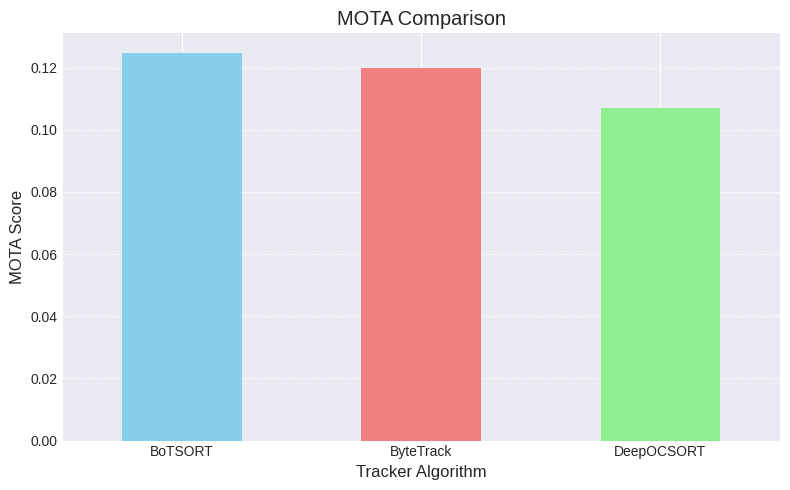

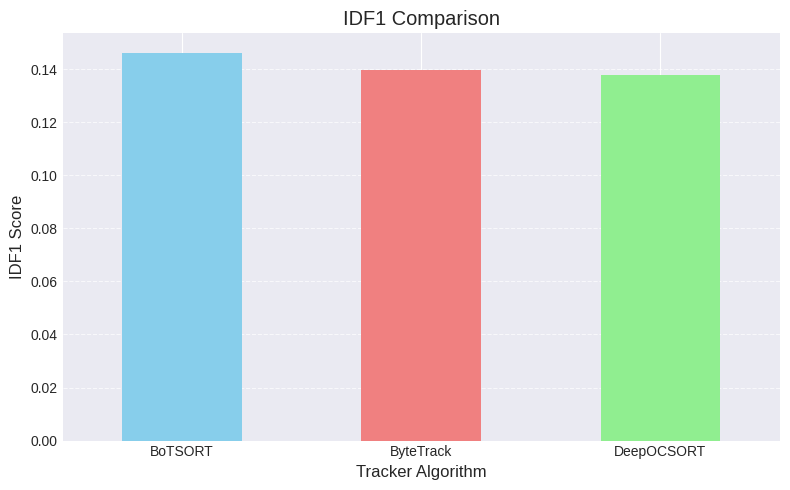

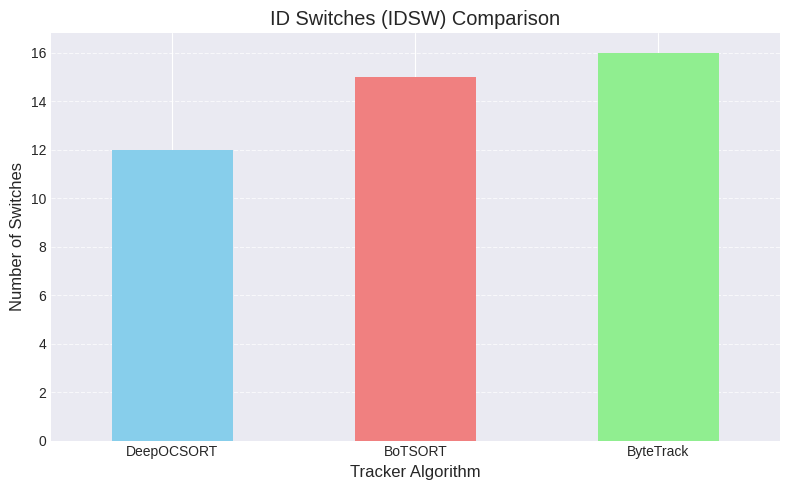

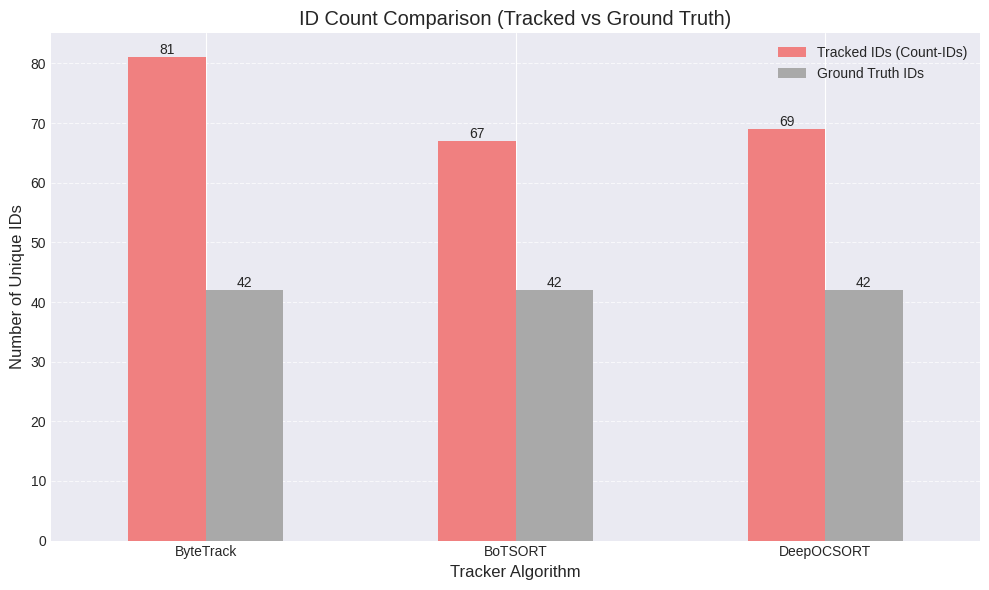

In [60]:
# --- Cell 9: Results Visualization ---
from tqdm import tqdm 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os # os 모듈 임포트 확인
from pathlib import Path # Path 임포트 확인
import seaborn

log = logging.getLogger(__name__) # 로거 가져오기 (Cell 3에서 설정됨)

# Cell 8에서 생성된 DataFrame 사용 시도, 없으면 CSV 파일 로드
results_df = None
if 'final_results_df' in locals() and isinstance(final_results_df, pd.DataFrame) and not final_results_df.empty:
    results_df = final_results_df
    log.info("Using existing final_results_df DataFrame for plotting.")
else:
    # Cell 8에서 저장한 CSV 경로 (Cell 5의 output_dir 사용)
    output_base_dir = Path(output_dir).resolve() # output_dir은 Cell 5에서 정의됨
    csv_path = output_base_dir / "results_yolov8m_0.1_msmt"     ### 시각화 원하는 csv 파일일
    if csv_path.is_file():
        try:
            results_df = pd.read_csv(csv_path, index_col='Algorithm') # Algorithm 컬럼을 인덱스로 사용
            log.info(f"Loaded results from {csv_path} for plotting.")
        except Exception as e:
            log.error(f"Failed to load results from CSV {csv_path}: {e}")
    else:
        log.error("Could not find existing DataFrame or CSV file to plot results.")

# --- Plotting ---
if results_df is not None and not results_df.empty:

    # 그래프 스타일 설정 (선택 사항)
    plt.style.use('seaborn-v0_8-darkgrid') # ggplot 

    # 1. MOTA 비교
    if 'MOTA' in results_df.columns:
        plt.figure(figsize=(8, 5))
        results_df['MOTA'].sort_values(ascending=False).plot(kind='bar', color=['skyblue', 'lightcoral', 'lightgreen'])
        plt.title('MOTA Comparison')
        plt.ylabel('MOTA Score')
        plt.xlabel('Tracker Algorithm')
        plt.xticks(rotation=0)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    # 2. IDF1 비교
    if 'IDF1' in results_df.columns:
        plt.figure(figsize=(8, 5))
        results_df['IDF1'].sort_values(ascending=False).plot(kind='bar', color=['skyblue', 'lightcoral', 'lightgreen'])
        plt.title('IDF1 Comparison')
        plt.ylabel('IDF1 Score')
        plt.xlabel('Tracker Algorithm')
        plt.xticks(rotation=0)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    # 3. IDSW 비교
    if 'IDSW' in results_df.columns:
        plt.figure(figsize=(8, 5))
        results_df['IDSW'].sort_values().plot(kind='bar', color=['skyblue', 'lightcoral', 'lightgreen']) # 낮은 값이 좋으므로 오름차순 정렬
        plt.title('ID Switches (IDSW) Comparison')
        plt.ylabel('Number of Switches')
        plt.xlabel('Tracker Algorithm')
        plt.xticks(rotation=0)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    # 4. IDS (Count-IDs) vs GT-IDS 비교 (Grouped Bar Chart)
    if 'IDS' in results_df.columns and 'GT-IDS' in results_df.columns:
        # NaN 값을 가진 알고리즘은 제외하거나 0으로 처리 필요
        plot_df = results_df[['IDS', 'GT-IDS']].dropna() # NaN 있는 행 제외

        if not plot_df.empty:
            ax = plot_df.plot(kind='bar', figsize=(10, 6), color=['lightcoral', 'darkgrey']) # IDS(추적), GT-IDS(실제) 색 구분
            plt.title('ID Count Comparison (Tracked vs Ground Truth)')
            plt.ylabel('Number of Unique IDs')
            plt.xlabel('Tracker Algorithm')
            plt.xticks(rotation=0)
            plt.legend(['Tracked IDs (Count-IDs)', 'Ground Truth IDs'])
            plt.grid(axis='y', linestyle='--', alpha=0.7)

            # 각 막대 위에 숫자 표시 (선택 사항)
            for container in ax.containers:
                ax.bar_label(container)

            plt.tight_layout()
            plt.show()
        else:
            log.warning("Not enough valid data to plot IDS vs GT-IDS comparison after dropping NaN.")

else:
    log.error("Cannot generate plots because evaluation results are not available.")

2025-05-07 10:50:18,455 - INFO - --- Loading result files for comparison plotting ---
2025-05-07 10:50:18,458 - INFO - Loading results for experiment: 'YOLOv8s' from /home/kms2069/Projects/boxmot/runs/mot_eval_notebook_val/results_yolov8s_0.82_polyp.csv
2025-05-07 10:50:18,486 - INFO -   Successfully loaded 3 rows.
2025-05-07 10:50:18,487 - INFO - Loading results for experiment: 'YOLOv8m' from /home/kms2069/Projects/boxmot/runs/mot_eval_notebook_val/results_yolov8m_0.82_polyp_2.csv
2025-05-07 10:50:18,491 - INFO -   Successfully loaded 3 rows.
2025-05-07 10:50:18,495 - INFO - Generating plot for metric: MOTA


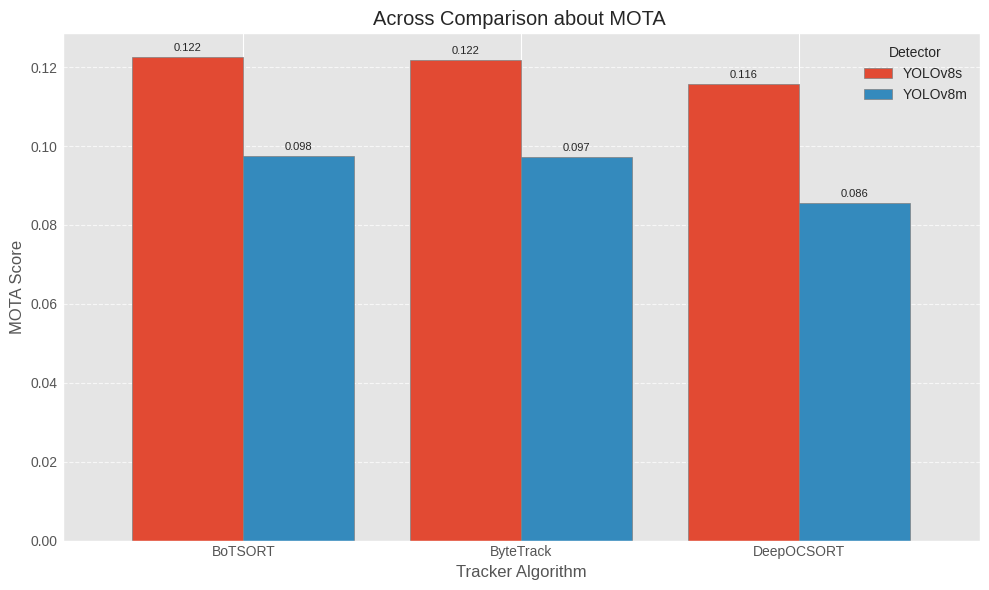

2025-05-07 10:50:18,749 - INFO - Generating plot for metric: IDF1


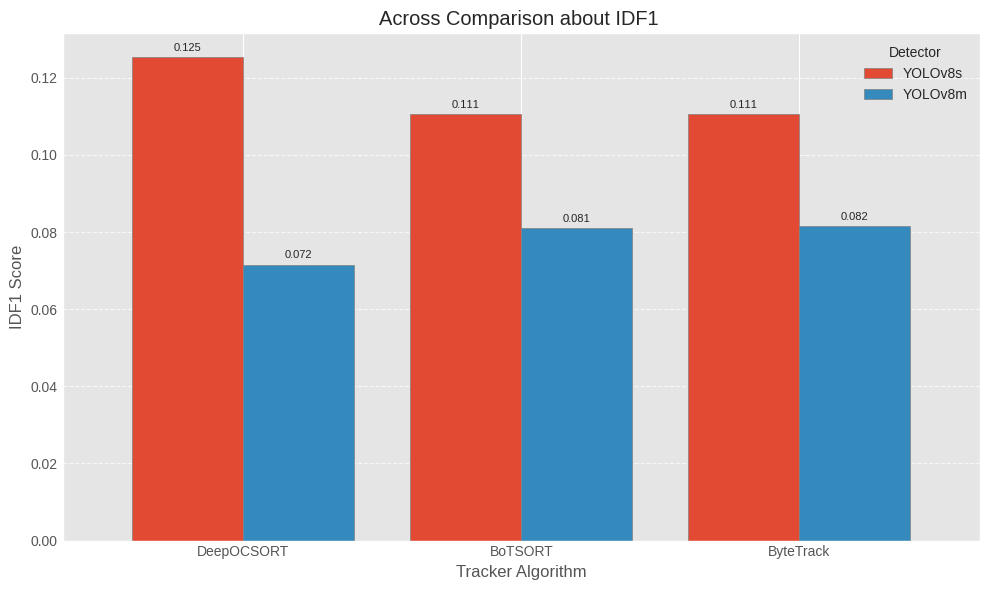

2025-05-07 10:50:18,892 - INFO - Generating plot for metric: IDSW


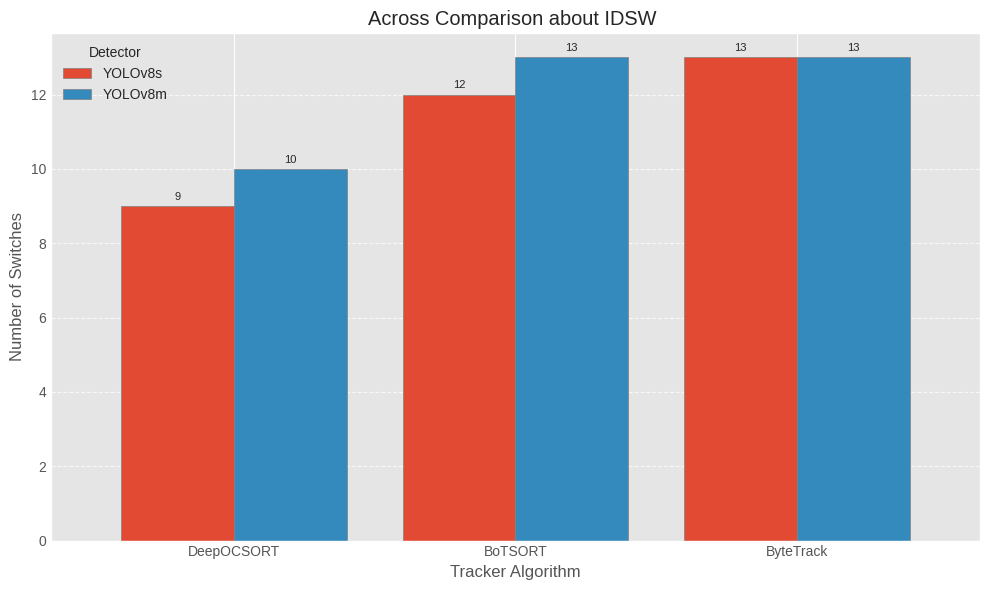

2025-05-07 10:50:19,036 - INFO - Generating plot for metric: IDS


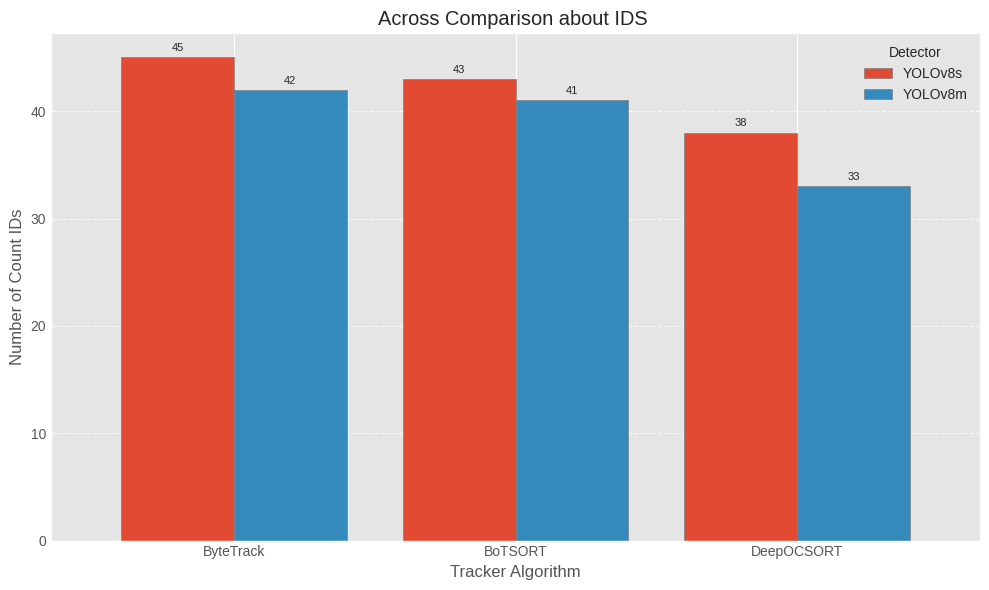

2025-05-07 10:50:19,170 - INFO - Generating plot for metric: GT-IDS


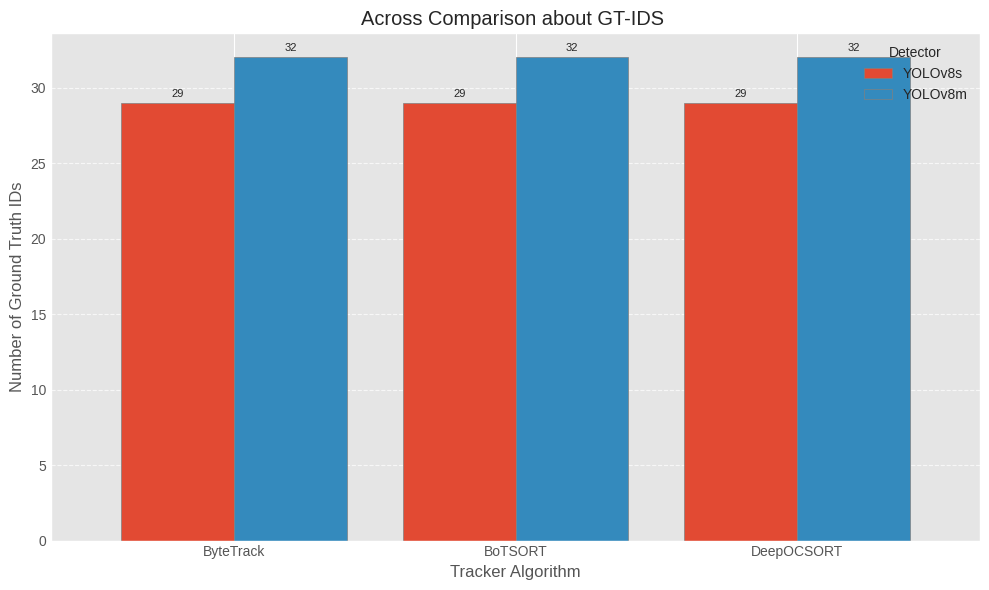

In [86]:
# --- Cell 10 (Revised - Fix CSV Loading) ---

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from pathlib import Path
import logging
import sys

log = logging.getLogger(__name__)

# --- !!! 중요: 각 실험 결과 CSV 파일 경로를 지정하세요 !!! ---
results_csv_paths = {
    'YOLOv8s': '/home/kms2069/Projects/boxmot/runs/mot_eval_notebook_val/results_yolov8s_0.82_polyp.csv',  # <--- 경로 확인!
    'YOLOv8m': '/home/kms2069/Projects/boxmot/runs/mot_eval_notebook_val/results_yolov8m_0.82_polyp_2.csv',  # <--- 경로 확인!
}
# ----------------------------------------------------------

# --- 데이터 로드 (수정됨) ---
loaded_data = {}
plot_ready = True
common_algorithms_index = None

log.info("--- Loading result files for comparison plotting ---")
for exp_name, csv_path_str in results_csv_paths.items():
    log.info(f"Loading results for experiment: '{exp_name}' from {csv_path_str}")
    csv_path = Path(csv_path_str)
    if csv_path.is_file():
        try:
            # --- *** 수정된 부분: index_col=0 사용 *** ---
            # 첫 번째 컬럼을 인덱스로 사용 (기본 저장 시 인덱스 이름이 없음)
            df = pd.read_csv(csv_path, index_col=0)
            # 인덱스 이름 설정 (선택 사항이지만 권장)
            df.index.name = 'Algorithm'
            # --- *** 수정 끝 *** ---

            loaded_data[exp_name] = df
            log.info(f"  Successfully loaded {len(df)} rows.")
            if common_algorithms_index is None:
                common_algorithms_index = df.index
            else:
                common_algorithms_index = common_algorithms_index.intersection(df.index)
        except Exception as e:
            log.error(f"  Failed to load or process CSV {csv_path}: {e}")
            plot_ready = False
    else:
        log.error(f"  CSV file not found at: {csv_path}")
        plot_ready = False

# --- Plotting ---
if plot_ready and loaded_data:
    # ... (나머지 플로팅 코드는 이전과 동일하게 유지) ...

    if common_algorithms_index is None or common_algorithms_index.empty:
         log.error("No common algorithms found across the loaded result files or no files loaded. Cannot plot.")
         plot_ready = False

    if plot_ready:
        plt.style.use('ggplot')
        metrics_to_plot = ['MOTA', 'IDF1', 'IDSW', 'IDS', 'GT-IDS']
        y_labels = {
        'MOTA': 'MOTA Score',
        'IDF1': 'IDF1 Score',
        'IDSW': 'Number of Switches',
        'IDS': 'Number of Count IDs',           
        'GT-IDS': 'Number of Ground Truth IDs'
        }
        lower_is_better = ['IDSW']

        for metric in metrics_to_plot:
            # ... (rest of plotting logic is unchanged) ...
            log.info(f"Generating plot for metric: {metric}")
            metric_data = {}
            valid_metric_in_all = True
            for exp_name, df in loaded_data.items():
                if metric in df.columns:
                    metric_data[exp_name] = df.loc[common_algorithms_index, metric]
                else:
                    log.warning(f"Metric '{metric}' not found in results for '{exp_name}'. Skipping this metric plot.")
                    valid_metric_in_all = False
                    break

            if not valid_metric_in_all or not metric_data:
                continue

            compare_df = pd.DataFrame(metric_data)
            compare_df = compare_df.dropna()

            if compare_df.empty:
                log.warning(f"No valid data to plot for metric '{metric}' after dropping NaN or filtering algorithms.")
                continue

            first_exp_name = list(loaded_data.keys())[0]
            ascending_order = metric in lower_is_better
            compare_df = compare_df.sort_values(by=first_exp_name, ascending=ascending_order)

            num_experiments = len(compare_df.columns)
            ax = compare_df.plot(kind='bar', figsize=(6 + num_experiments * 2, 6), edgecolor='grey', width=0.8)
            plt.title(f'Across Comparison about {metric} ')
            plt.ylabel(y_labels.get(metric, metric))
            plt.xlabel('Tracker Algorithm')
            plt.xticks(rotation=0)
            plt.legend(title='Detector')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            for container in ax.containers:
                fmt = '%.3f' if metric in ['MOTA', 'IDF1'] else '%d'
                try:
                    ax.bar_label(container, fmt=fmt, padding=3, fontsize=8, rotation=0)
                except Exception as label_e:
                     log.warning(f"Could not add bar labels for {metric}: {label_e}")

            plt.tight_layout()
            plt.show()
else:
    log.error("Cannot generate comparison plots. Ensure all specified CSV files exist and contain valid data.")

2025-05-07 10:51:01,728 - INFO - --- Loading result files for comparison plotting ---
2025-05-07 10:51:01,729 - INFO - Loading results for experiment: 'YOLOv8s' from /home/kms2069/Projects/boxmot/runs/mot_eval_notebook_val/results_yolov8s_0.82_polyp.csv
2025-05-07 10:51:01,733 - INFO -   Successfully loaded 3 rows.
2025-05-07 10:51:01,734 - INFO - Loading results for experiment: 'YOLOv8m' from /home/kms2069/Projects/boxmot/runs/mot_eval_notebook_val/results_yolov8m_0.82_polyp_2.csv
2025-05-07 10:51:01,738 - INFO -   Successfully loaded 3 rows.
2025-05-07 10:51:01,740 - INFO - Generating plot for metric: MOTA


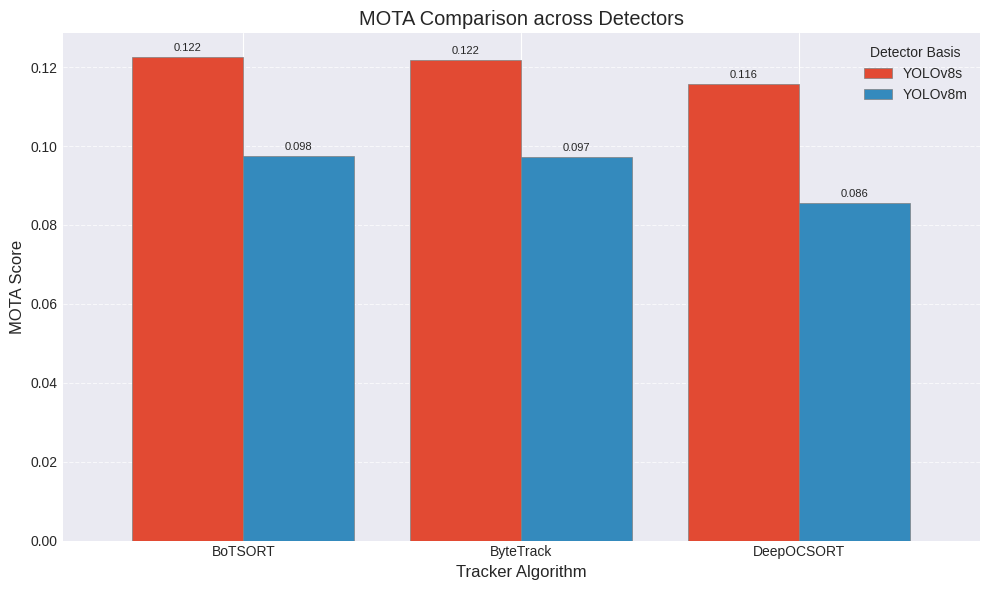

2025-05-07 10:51:01,887 - INFO - Generating plot for metric: IDF1


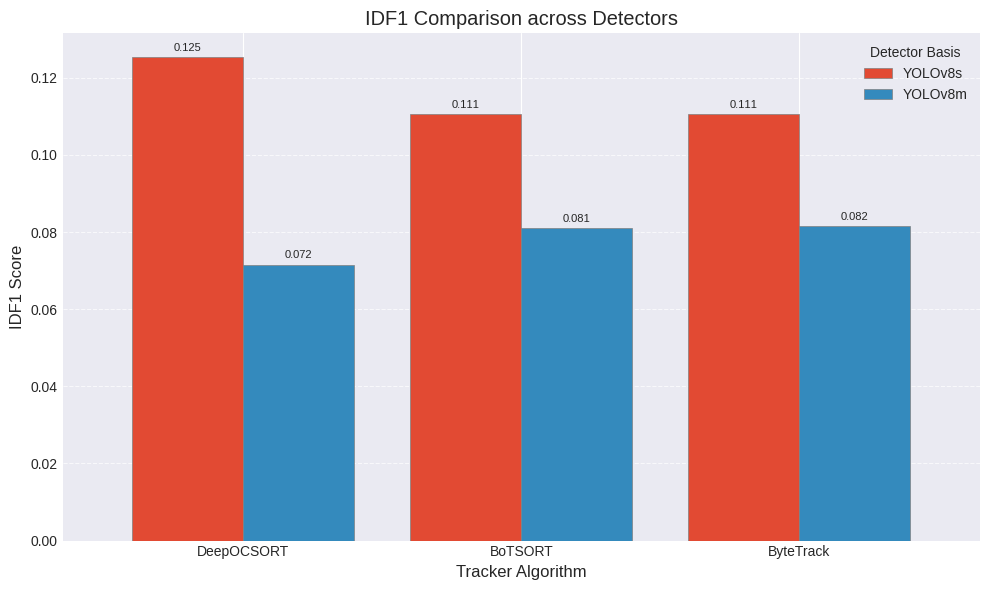

2025-05-07 10:51:02,025 - INFO - Generating plot for metric: IDSW


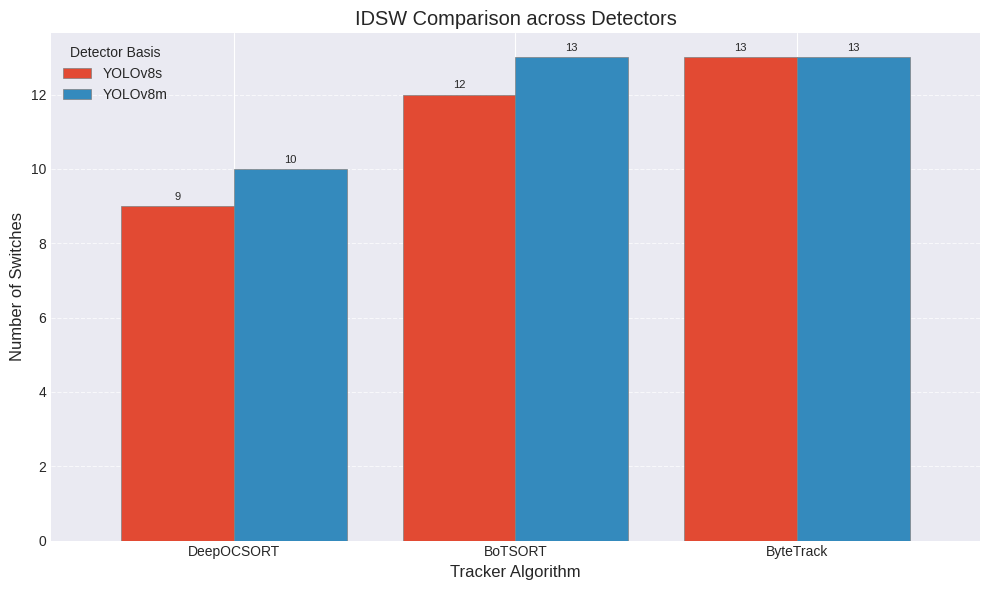

2025-05-07 10:51:02,157 - INFO - Generating combined ID Count vs GT ID plot


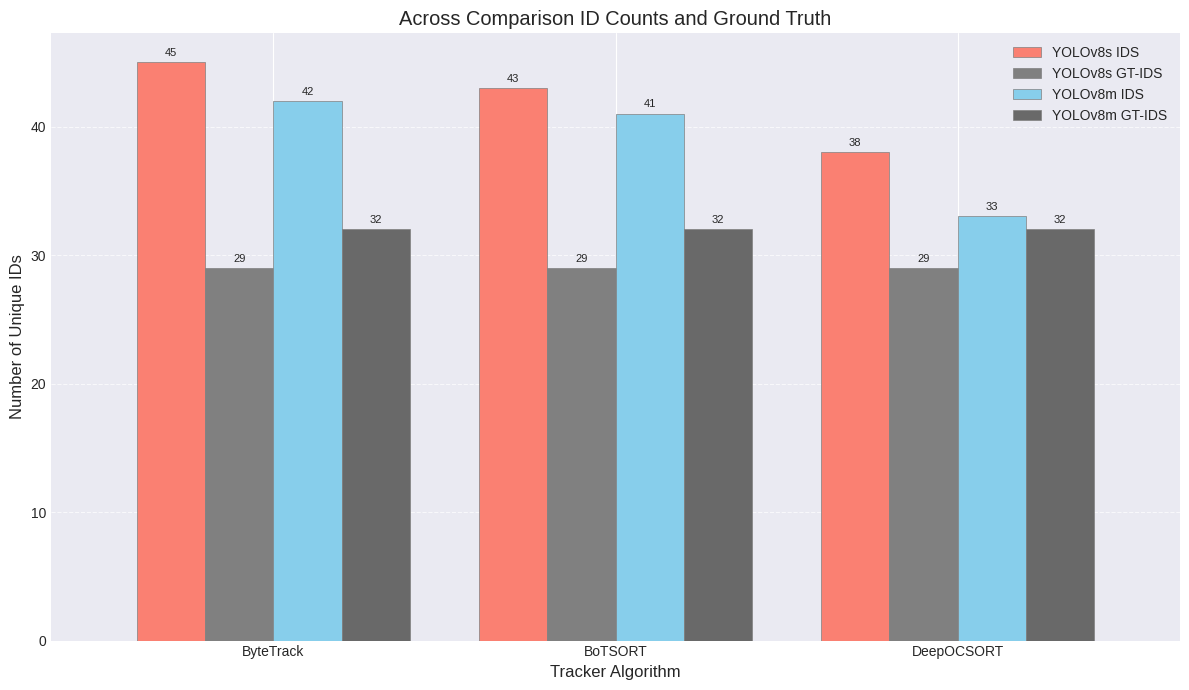

In [87]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from pathlib import Path
import logging
import sys

log = logging.getLogger(__name__)

# --- !!! 중요: 각 실험 결과 CSV 파일 경로를 지정하세요 !!! ---
results_csv_paths = {
    'YOLOv8s': '/home/kms2069/Projects/boxmot/runs/mot_eval_notebook_val/results_yolov8s_0.82_polyp.csv',  # <--- 경로 확인!
    'YOLOv8m': '/home/kms2069/Projects/boxmot/runs/mot_eval_notebook_val/results_yolov8m_0.82_polyp_2.csv',  # <--- 경로 확인!
}
# ----------------------------------------------------------

# --- 데이터 로드 ---
loaded_data = {}
plot_ready = True
common_algorithms_index = None

log.info("--- Loading result files for comparison plotting ---")
for exp_name, csv_path_str in results_csv_paths.items():
    log.info(f"Loading results for experiment: '{exp_name}' from {csv_path_str}")
    csv_path = Path(csv_path_str)
    if csv_path.is_file():
        try:
            df = pd.read_csv(csv_path, index_col=0) # 첫 번째 컬럼을 인덱스로 사용
            df.index.name = 'Algorithm' # 인덱스 이름 명시
            loaded_data[exp_name] = df
            log.info(f"  Successfully loaded {len(df)} rows.")
            if common_algorithms_index is None:
                common_algorithms_index = df.index
            else:
                common_algorithms_index = common_algorithms_index.intersection(df.index)
        except Exception as e:
            log.error(f"  Failed to load or process CSV {csv_path}: {e}")
            plot_ready = False
    else:
        log.error(f"  CSV file not found at: {csv_path}")
        plot_ready = False

# --- Plotting ---
if plot_ready and loaded_data:

    if common_algorithms_index is None or common_algorithms_index.empty:
         log.error("No common algorithms found across the loaded result files or no files loaded. Cannot plot.")
         plot_ready = False

    if plot_ready:
        plt.style.use('seaborn-v0_8-darkgrid') # ggplot

        # 일반 지표 플로팅 (MOTA, IDF1, IDSW) - 이전과 동일하게 유지
        metrics_to_plot_individual = ['MOTA', 'IDF1', 'IDSW']
        y_labels_individual = {
            'MOTA': 'MOTA Score', 'IDF1': 'IDF1 Score', 'IDSW': 'Number of Switches'
        }
        lower_is_better_individual = ['IDSW']

        for metric in metrics_to_plot_individual:
            log.info(f"Generating plot for metric: {metric}")
            metric_data = {}
            valid_metric_in_all = True
            for exp_name, df in loaded_data.items():
                if metric in df.columns:
                    metric_data[exp_name] = df.loc[common_algorithms_index, metric]
                else:
                    log.warning(f"Metric '{metric}' not found in results for '{exp_name}'. Skipping this metric plot.")
                    valid_metric_in_all = False
                    break
            if not valid_metric_in_all or not metric_data: continue
            compare_df = pd.DataFrame(metric_data).dropna()
            if compare_df.empty:
                log.warning(f"No valid data to plot for metric '{metric}' after dropping NaN or filtering algorithms.")
                continue

            first_exp_name = list(loaded_data.keys())[0]
            ascending_order = metric in lower_is_better_individual
            compare_df = compare_df.sort_values(by=first_exp_name, ascending=ascending_order)
            num_experiments = len(compare_df.columns)
            ax = compare_df.plot(kind='bar', figsize=(6 + num_experiments * 2, 6), edgecolor='grey', width=0.8)
            plt.title(f'{metric} Comparison across Detectors')
            plt.ylabel(y_labels_individual.get(metric, metric))
            plt.xlabel('Tracker Algorithm')
            plt.xticks(rotation=0)
            plt.legend(title='Detector Basis')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            for container in ax.containers:
                fmt = '%.3f' if metric in ['MOTA', 'IDF1'] else '%d'
                try: ax.bar_label(container, fmt=fmt, padding=3, fontsize=8, rotation=0)
                except Exception as label_e: log.warning(f"Could not add bar labels for {metric}: {label_e}")
            plt.tight_layout()
            plt.show()

        # --- *** 수정된 ID Count vs GT ID 통합 비교 그래프 *** ---
        log.info("Generating combined ID Count vs GT ID plot")
        plot_data_ids_gt = {}
        experiments = list(loaded_data.keys()) # 예: ['YOLOv8s', 'YOLOv8m']

        for algo in common_algorithms_index:
            algo_data = {}
            for exp_name in experiments:
                df = loaded_data[exp_name]
                if 'IDS' in df.columns and 'GT-IDS' in df.columns:
                    # 각 실험(Detector)별로 IDS와 GT-IDS 값을 가져옴
                    algo_data[f'{exp_name} IDS'] = df.loc[algo, 'IDS']
                    # GT-IDS는 Detector에 따라 달라질 수 있으므로, 해당 실험의 GT-IDS를 사용
                    algo_data[f'{exp_name} GT-IDS'] = df.loc[algo, 'GT-IDS']
                else:
                    log.warning(f"IDS or GT-IDS not found for {algo} in {exp_name}. Plot may be incomplete.")
                    # 값이 없을 경우 NaN으로 채워서 DataFrame 구조 유지
                    algo_data[f'{exp_name} IDS'] = np.nan
                    algo_data[f'{exp_name} GT-IDS'] = np.nan
            plot_data_ids_gt[algo] = algo_data

        compare_ids_gt_df = pd.DataFrame.from_dict(plot_data_ids_gt, orient='index')

        if not compare_ids_gt_df.empty:
            # 컬럼 순서 정의 (예: s_IDS, s_GT, m_IDS, m_GT)
            column_order = []
            colors = []
            color_map = {'IDS': 'lightcoral', 'GT-IDS': 'darkgrey'} # 기본 색상
            detector_colors = {'YOLOv8s': ['salmon', 'grey'], 'YOLOv8m': ['skyblue', 'dimgrey']} # Detector별 색상 쌍

            for exp_name in experiments:
                ids_col_name = f'{exp_name} IDS'
                gt_col_name = f'{exp_name} GT-IDS'
                if ids_col_name in compare_ids_gt_df.columns:
                    column_order.append(ids_col_name)
                    colors.append(detector_colors.get(exp_name, ['blue', 'black'])[0]) # Detector별 IDS 색상
                if gt_col_name in compare_ids_gt_df.columns:
                    column_order.append(gt_col_name)
                    colors.append(detector_colors.get(exp_name, ['blue', 'black'])[1]) # Detector별 GT-IDS 색상

            compare_ids_gt_df = compare_ids_gt_df[column_order] # 컬럼 순서 적용

            ax = compare_ids_gt_df.plot(kind='bar', figsize=(8 + len(experiments) * 2, 7),
                                         edgecolor='grey', width=0.8, color=colors if len(colors) == len(column_order) else None) # 색상 적용

            plt.title('Across Comparison ID Counts and Ground Truth')
            plt.ylabel('Number of Unique IDs')
            plt.xlabel('Tracker Algorithm')
            plt.xticks(rotation=0)
            # 범례 핸들링이 복잡해질 수 있으므로, 필요시 수동 생성 또는 색상으로 구분
            # plt.legend(title='Metric (Detector Specific)')
            plt.grid(axis='y', linestyle='--', alpha=0.7)

            for container in ax.containers:
                try: ax.bar_label(container, fmt='%d', padding=3, fontsize=8, rotation=0)
                except Exception as label_e: log.warning(f"Could not add bar labels for ID/GT-ID plot: {label_e}")

            plt.tight_layout()
            plt.show()
        else:
            log.warning("Not enough data to plot ID Count vs GT ID comparison.")
else:
    log.error("Cannot generate comparison plots. Ensure all specified CSV files exist and contain valid data.")

2025-05-07 11:02:21,789 - INFO - --- Loading result files for comparison plotting ---
2025-05-07 11:02:21,790 - INFO - Loading results for experiment: 'YOLOv8s' from /home/kms2069/Projects/boxmot/runs/mot_eval_notebook_val/results_yolov8s_0.82_polyp.csv
2025-05-07 11:02:21,795 - INFO -   Successfully loaded 3 rows.
2025-05-07 11:02:21,796 - INFO - Loading results for experiment: 'YOLOv8m' from /home/kms2069/Projects/boxmot/runs/mot_eval_notebook_val/results_yolov8m_0.82_polyp_2.csv
2025-05-07 11:02:21,798 - INFO -   Successfully loaded 3 rows.
2025-05-07 11:02:21,800 - INFO - Generating plot for metric: MOTA


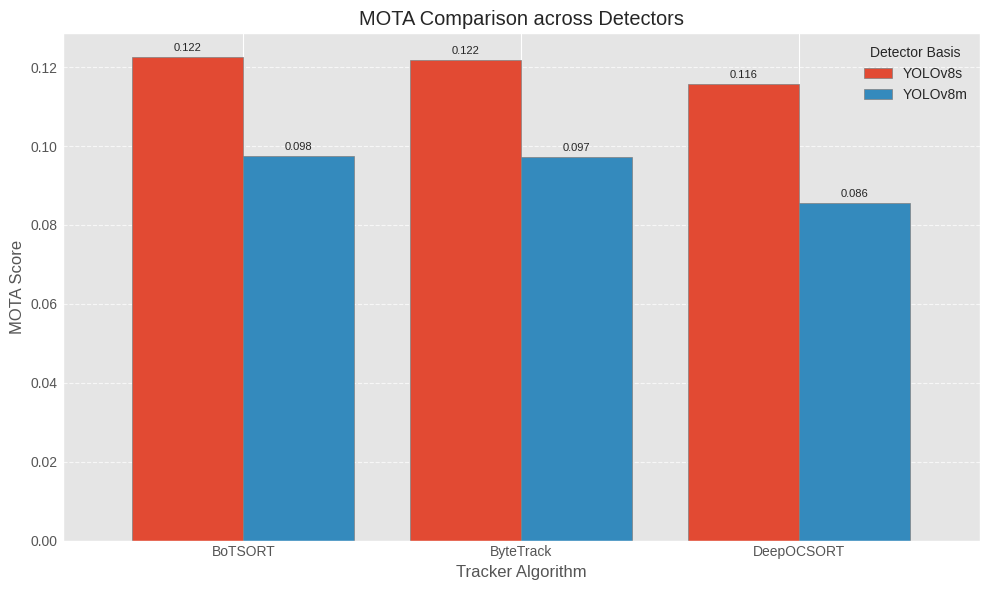

2025-05-07 11:02:21,932 - INFO - Generating plot for metric: IDF1


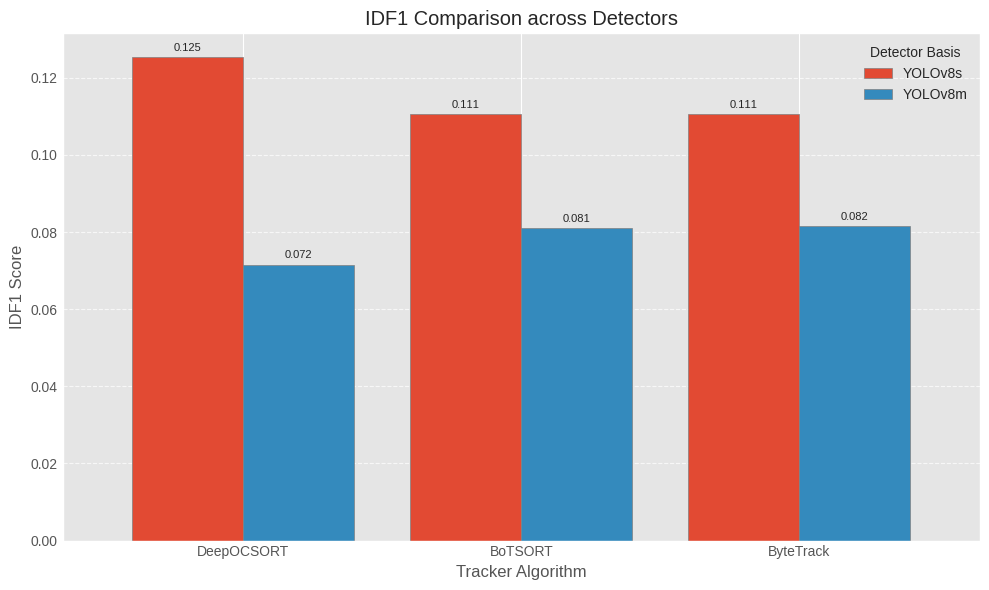

2025-05-07 11:02:22,068 - INFO - Generating plot for metric: IDSW


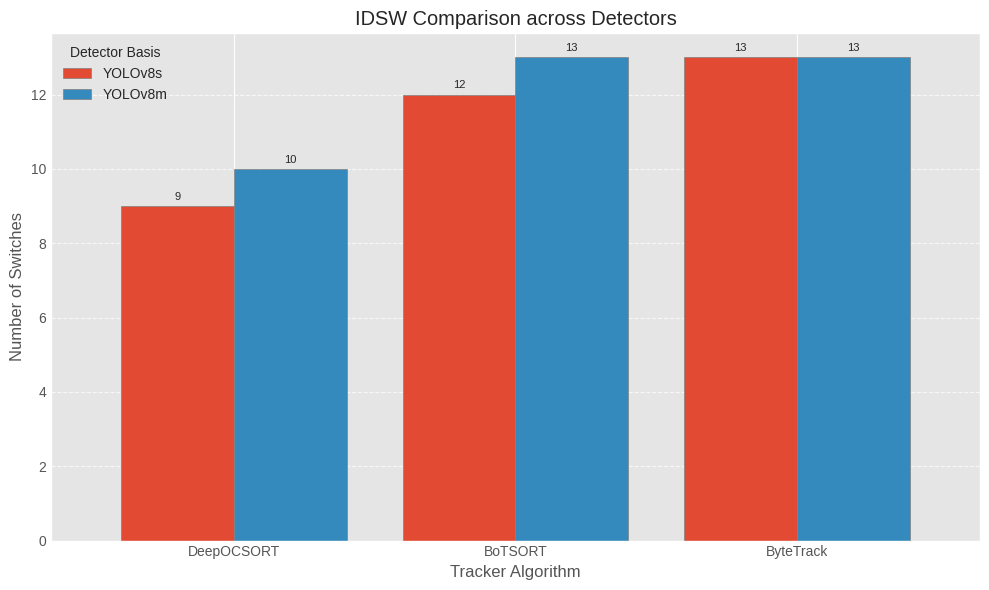

2025-05-07 11:02:22,197 - INFO - Generating specific ID Count (s & m) vs. GT-IDS (m-only) plot


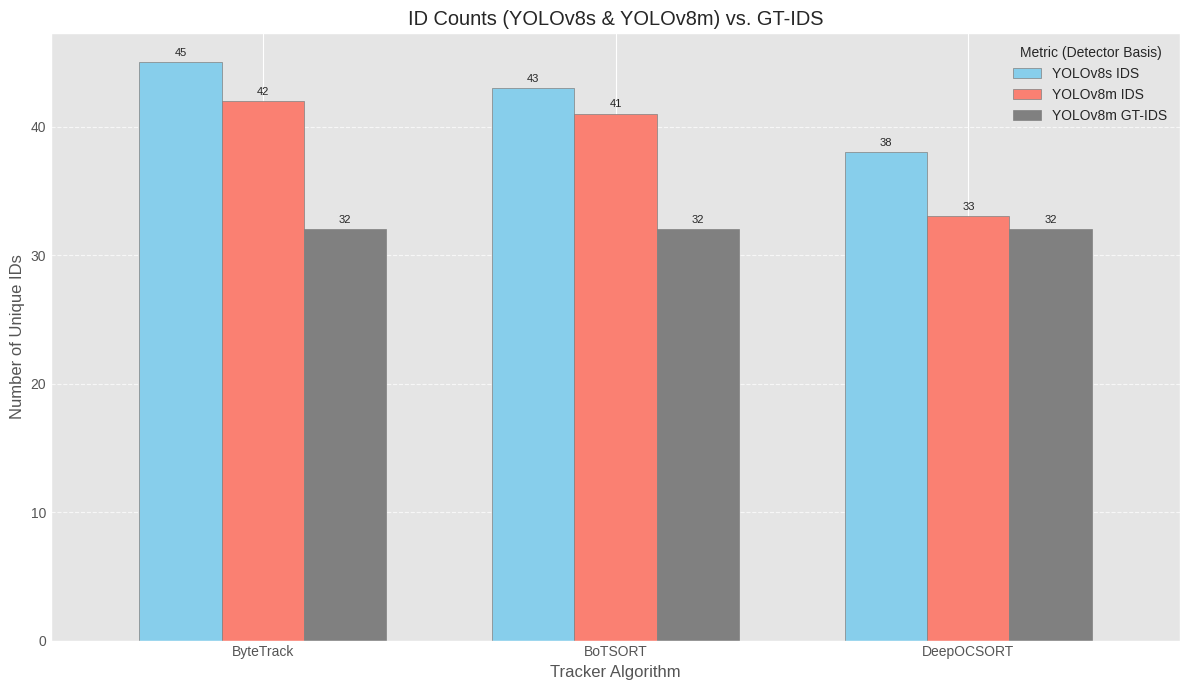

2025-05-07 11:02:22,345 - INFO - Generating plot for metric: GT-IDS


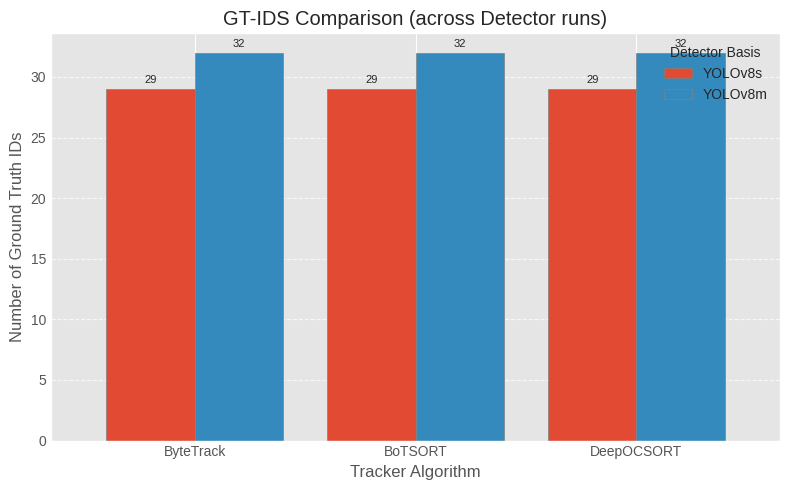

In [ ]:
# --- Cell 10 (Plotting Cell - YOLOv8s 기반의 IDS, YOLOv8m 기반의 IDS, 그리고 YOLOv8m 기반의 GT-IDS만을 함께 비교) ---

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from pathlib import Path
import logging
import sys

log = logging.getLogger(__name__)

# --- !!! 중요: 각 실험 결과 CSV 파일 경로를 지정하세요 !!! ---
results_csv_paths = {
    'YOLOv8s': '/home/kms2069/Projects/boxmot/runs/mot_eval_notebook_val/results_yolov8s_0.82_polyp.csv',  # <--- 경로 확인!
    'YOLOv8m': '/home/kms2069/Projects/boxmot/runs/mot_eval_notebook_val/results_yolov8m_0.82_polyp_2.csv',  # <--- 경로 확인!
}
# ----------------------------------------------------------

# --- 데이터 로드 ---
loaded_data = {}
plot_ready = True
common_algorithms_index = None

log.info("--- Loading result files for comparison plotting ---")
for exp_name, csv_path_str in results_csv_paths.items():
    log.info(f"Loading results for experiment: '{exp_name}' from {csv_path_str}")
    csv_path = Path(csv_path_str)
    if csv_path.is_file():
        try:
            df = pd.read_csv(csv_path, index_col=0)
            df.index.name = 'Algorithm'
            loaded_data[exp_name] = df
            log.info(f"  Successfully loaded {len(df)} rows.")
            if common_algorithms_index is None:
                common_algorithms_index = df.index
            else:
                common_algorithms_index = common_algorithms_index.intersection(df.index)
        except Exception as e:
            log.error(f"  Failed to load or process CSV {csv_path}: {e}")
            plot_ready = False
    else:
        log.error(f"  CSV file not found at: {csv_path}")
        plot_ready = False

# --- Plotting ---
if plot_ready and loaded_data:

    if common_algorithms_index is None or common_algorithms_index.empty:
         log.error("No common algorithms found across the loaded result files or no files loaded. Cannot plot.")
         plot_ready = False

    if plot_ready:
        plt.style.use('ggplot')

        # --- 일반 지표 플로팅 (MOTA, IDF1, IDSW) ---
        metrics_to_plot_individual = ['MOTA', 'IDF1', 'IDSW']
        y_labels_individual = {
            'MOTA': 'MOTA Score', 'IDF1': 'IDF1 Score', 'IDSW': 'Number of Switches'
        }
        lower_is_better_individual = ['IDSW']

        for metric in metrics_to_plot_individual:
            # ... (이전 답변의 MOTA, IDF1, IDSW 플로팅 로직은 동일하게 유지) ...
            log.info(f"Generating plot for metric: {metric}")
            metric_data = {}
            valid_metric_in_all = True
            for exp_name, df in loaded_data.items():
                if metric in df.columns:
                    metric_data[exp_name] = df.loc[common_algorithms_index, metric]
                else:
                    log.warning(f"Metric '{metric}' not found in results for '{exp_name}'. Skipping this metric plot.")
                    valid_metric_in_all = False
                    break
            if not valid_metric_in_all or not metric_data: continue
            compare_df = pd.DataFrame(metric_data).dropna()
            if compare_df.empty:
                log.warning(f"No valid data to plot for metric '{metric}' after dropping NaN or filtering algorithms.")
                continue

            first_exp_name_sort = list(loaded_data.keys())[0] # 정렬 기준 실험
            ascending_order = metric in lower_is_better_individual
            compare_df = compare_df.sort_values(by=first_exp_name_sort, ascending=ascending_order) # by 인자 수정
            num_experiments_plot = len(compare_df.columns) # 변수 이름 수정
            ax = compare_df.plot(kind='bar', figsize=(6 + num_experiments_plot * 2, 6), edgecolor='grey', width=0.8)
            plt.title(f'{metric} Comparison across Detectors')
            plt.ylabel(y_labels_individual.get(metric, metric))
            plt.xlabel('Tracker Algorithm')
            plt.xticks(rotation=0)
            plt.legend(title='Detector Basis')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            for container in ax.containers:
                fmt = '%.3f' if metric in ['MOTA', 'IDF1'] else '%d'
                try: ax.bar_label(container, fmt=fmt, padding=3, fontsize=8, rotation=0)
                except Exception as label_e: log.warning(f"Could not add bar labels for {metric}: {label_e}")
            plt.tight_layout()
            plt.show()


        # --- *** 수정된 ID Count (YOLOv8s & YOLOv8m) vs. GT-IDS (YOLOv8m 기준) 비교 그래프 *** ---
        log.info("Generating specific ID Count (s & m) vs. GT-IDS (m-only) plot")
        plot_data_specific = {}
        yolov8s_exp_name = 'YOLOv8s' # results_csv_paths의 키와 일치해야 함
        yolov8m_exp_name = 'YOLOv8m' # results_csv_paths의 키와 일치해야 함

        # 두 실험이 모두 로드되었는지 확인
        if yolov8s_exp_name not in loaded_data or yolov8m_exp_name not in loaded_data:
            log.error("YOLOv8s and/or YOLOv8m data not found in loaded_data. Cannot generate specific ID plot.")
        else:
            df_s = loaded_data[yolov8s_exp_name]
            df_m = loaded_data[yolov8m_exp_name]

            for algo in common_algorithms_index:
                algo_data = {}
                # YOLOv8s IDS
                if 'IDS' in df_s.columns:
                    algo_data[f'{yolov8s_exp_name} IDS'] = df_s.loc[algo, 'IDS']
                else:
                    log.warning(f"IDS not found for {algo} in {yolov8s_exp_name} data.")
                    algo_data[f'{yolov8s_exp_name} IDS'] = np.nan

                # YOLOv8m IDS
                if 'IDS' in df_m.columns:
                    algo_data[f'{yolov8m_exp_name} IDS'] = df_m.loc[algo, 'IDS']
                else:
                    log.warning(f"IDS not found for {algo} in {yolov8m_exp_name} data.")
                    algo_data[f'{yolov8m_exp_name} IDS'] = np.nan

                # YOLOv8m GT-IDS (YOLOv8m 실행 시의 GT-IDS를 기준으로 사용)
                if 'GT-IDS' in df_m.columns:
                    algo_data[f'{yolov8m_exp_name} GT-IDS'] = df_m.loc[algo, 'GT-IDS']
                else:
                    log.warning(f"GT-IDS not found for {algo} in {yolov8m_exp_name} data.")
                    algo_data[f'{yolov8m_exp_name} GT-IDS'] = np.nan

                plot_data_specific[algo] = algo_data

            compare_specific_df = pd.DataFrame.from_dict(plot_data_specific, orient='index')

            if not compare_specific_df.empty:
                # 컬럼 순서 및 플로팅에 사용할 컬럼 정의
                cols_for_plot = [f'{yolov8s_exp_name} IDS', f'{yolov8m_exp_name} IDS', f'{yolov8m_exp_name} GT-IDS']
                # 실제 존재하는 컬럼만 필터링 (데이터 로딩 실패 등으로 컬럼이 없을 수 있음)
                cols_for_plot = [col for col in cols_for_plot if col in compare_specific_df.columns]

                if len(cols_for_plot) < 3: # 필요한 3개 컬럼이 모두 없으면 경고
                     log.warning(f"Not all required columns ({cols_for_plot}) are available for the specific ID plot. Skipping.")
                else:
                    compare_specific_df = compare_specific_df[cols_for_plot].dropna() # NaN 있는 행 제거

                    if not compare_specific_df.empty:
                        # 색상 지정
                        colors = ['skyblue', 'salmon', 'grey'] # YOLOv8s IDS, YOLOv8m IDS, YOLOv8m GT-IDS 순

                        ax = compare_specific_df.plot(kind='bar', figsize=(12, 7),
                                                     edgecolor='grey', width=0.7, color=colors)

                        plt.title('ID Counts vs. GT-IDS')
                        plt.ylabel('Number of Unique IDs')
                        plt.xlabel('Tracker Algorithm')
                        plt.xticks(rotation=0)
                        # 범례는 컬럼 이름으로 자동 생성됨
                        plt.legend(title='Metric (Detector Basis)')
                        plt.grid(axis='y', linestyle='--', alpha=0.7)

                        for container in ax.containers:
                            try: ax.bar_label(container, fmt='%d', padding=3, fontsize=8, rotation=0)
                            except Exception as label_e: log.warning(f"Could not add bar labels for specific ID plot: {label_e}")

                        plt.tight_layout()
                        plt.show()
                    else:
                        log.warning("No valid data for the specific ID Count vs GT-IDS plot after NaN drop.")
            else:
                log.warning("Could not generate DataFrame for specific ID Count vs GT-IDS plot.")


        # --- GT-IDS 값 자체 비교 그래프 (선택 사항, 이전 로직대로 유지) ---
        # 만약 GT-IDS 값이 두 실험 간에 실제로 어떻게 다른지 보고 싶다면 이 그래프도 유용
        metric_gt_ids = 'GT-IDS'
        if metric_gt_ids in df_s.columns and metric_gt_ids in df_m.columns:
            log.info(f"Generating plot for metric: {metric_gt_ids}")
            gt_ids_data = {
                yolov8s_exp_name: df_s.loc[common_algorithms_index, metric_gt_ids],
                yolov8m_exp_name: df_m.loc[common_algorithms_index, metric_gt_ids]
            }
            compare_gt_ids_df = pd.DataFrame(gt_ids_data).dropna()

            if not compare_gt_ids_df.empty:
                ax = compare_gt_ids_df.plot(kind='bar', figsize=(8, 5), edgecolor='grey', width=0.8)
                plt.title('GT-IDS Comparison (across Detector runs)')
                plt.ylabel('Number of Ground Truth IDs')
                plt.xlabel('Tracker Algorithm')
                plt.xticks(rotation=0)
                plt.legend(title='Detector Basis')
                plt.grid(axis='y', linestyle='--', alpha=0.7)
                for container in ax.containers:
                    try: ax.bar_label(container, fmt='%d', padding=3, fontsize=8, rotation=0)
                    except Exception as label_e: log.warning(f"Could not add bar labels for {metric_gt_ids}: {label_e}")
                plt.tight_layout()
                plt.show()
            else:
                log.warning(f"No valid data to plot for {metric_gt_ids} comparison.")

else:
    log.error("Cannot generate comparison plots. Ensure all specified CSV files exist and contain valid data.")

In [36]:
from graphviz import Source

dot = """
digraph pipeline {
  rankdir=LR;
  graph [bgcolor=white];
  node [shape=box, style="rounded,filled", fontname="Helvetica", fontsize=14];

  "Video sequence" [fillcolor="#B3D4FC"];
  "Object detector" [fillcolor="#FFD8A9"];
  "Data association" [fillcolor="#C3FDB8"];
  "Trajectory"      [fillcolor="#FDC3C3"];

  "Video sequence" -> "Object detector" [arrowhead="vee", penwidth=2];
  "Object detector" -> "Data association" [arrowhead="vee", penwidth=2];
  "Data association" -> "Trajectory"     [arrowhead="vee", penwidth=2];
}
"""

# Render and display the styled diagram
Source(dot)

ModuleNotFoundError: No module named 'graphviz'

### 실행주의

In [ ]:
!python3 tracking/val.py --yolo-model yolov8m_polypPNG7.4_best.pt --reid-model osnet_ain_x1_0_polyp.pt --tracking-method deepocsort botsort bytetrack --verbose --source ./assets/polyp_test_mot/train